In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from reference import get_file_names, get_histplot, get_scatter_marker_size, get_coeffs
from scipy import stats
import seaborn as sns
from brokenaxes import brokenaxes

In [2]:
# dataframes and merges
df_ref = pd.read_csv('./vidas_data/cross_ref_cols_tabs.csv')
df_referral = pd.read_csv('./vidas_data/survival_time.csv', parse_dates=['EOH', 'SOH'])
df_ps = pd.read_csv('./vidas_data/wH_DirectTable_DOLORE_MED_e_INF_VIDAS.csv', parse_dates=['TimeStamp_Insert'])
df_ps = df_ps[['IDEHR', 'EHRType', 'TimeStamp_Insert', 'Sollievo_dolore']].dropna().rename(columns={'Sollievo_dolore': 'pain_relief'})
df_pa = pd.merge(df_referral, df_ps, on=['IDEHR', 'EHRType']).dropna().sort_values(by=['IDEHR', 'TimeStamp_Insert'], ascending=[True, True]).reset_index(drop=True)

In [3]:
df_pa

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,pain_relief
0,1375,2017-01-19 12:00:00,EHR,2015-10-01 09:30:19.710,476.0,Palliative (Non-Malignant),10,2015-10-29 14:52:42.597,70%#7
1,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-10 11:12:02.063,90%#9
2,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-10 17:16:59.183,90%#9
3,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-11 03:27:36.353,100% - Sollievo totale#10
4,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-11 03:35:21.460,100% - Sollievo totale#10
...,...,...,...,...,...,...,...,...,...
88387,29090,2020-07-16 00:00:01,AMB,2020-06-25 16:51:30.637,20.0,GI Tract,1539,2020-07-14 13:56:19.160,90%#9
88388,29147,2020-07-03 03:00:06,AMB,2020-06-29 16:51:34.273,3.0,Palliative (Non-Malignant),5849,2020-06-30 12:47:54.043,90%#9
88389,29258,2020-07-16 05:00:46,AMB,2020-07-07 11:58:21.533,8.0,Lung,1623,2020-07-13 10:29:34.797,80%#8
88390,29258,2020-07-16 05:00:46,AMB,2020-07-07 11:58:21.533,8.0,Lung,1623,2020-07-14 11:14:53.943,80%#8


In [4]:
df_pa.pain_relief.unique()

array(['70%#7', '90%#9', '100% - Sollievo totale#10', '80%#8',
       '0% - Nessun sollievo#0', 'N.R.', '60%#6', '50%#5', '30%#3',
       '20%#2', '40%#4', '10%#1'], dtype=object)

In [5]:
# clean up pain relief entries
df_pa.loc[df_pa['pain_relief'] == 'N.R.', 'pain_relief'] = np.nan
df_pa['pain_relief'] = df_pa.pain_relief.str.findall('(\d+)\%')
df_pa['pain_relief'] = df_pa['pain_relief'].apply(lambda x: np.nan if isinstance(x, float) else int(x[0]))
df_pa = df_pa.dropna()

In [6]:
# display dframe
df_pa

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,pain_relief
0,1375,2017-01-19 12:00:00,EHR,2015-10-01 09:30:19.710,476.0,Palliative (Non-Malignant),10,2015-10-29 14:52:42.597,70.0
1,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-10 11:12:02.063,90.0
2,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-10 17:16:59.183,90.0
3,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-11 03:27:36.353,100.0
4,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-11 03:35:21.460,100.0
...,...,...,...,...,...,...,...,...,...
88387,29090,2020-07-16 00:00:01,AMB,2020-06-25 16:51:30.637,20.0,GI Tract,1539,2020-07-14 13:56:19.160,90.0
88388,29147,2020-07-03 03:00:06,AMB,2020-06-29 16:51:34.273,3.0,Palliative (Non-Malignant),5849,2020-06-30 12:47:54.043,90.0
88389,29258,2020-07-16 05:00:46,AMB,2020-07-07 11:58:21.533,8.0,Lung,1623,2020-07-13 10:29:34.797,80.0
88390,29258,2020-07-16 05:00:46,AMB,2020-07-07 11:58:21.533,8.0,Lung,1623,2020-07-14 11:14:53.943,80.0


In [7]:
# generate statstics on the observations
df_pa.pain_relief.value_counts()

100.0    54912
90.0     23244
80.0      7630
70.0      1677
60.0       494
50.0       219
40.0        90
0.0         46
30.0        44
20.0        29
10.0         2
Name: pain_relief, dtype: int64

In [8]:
dft = df_pa[['IDEHR', 'TimeStamp_Insert']].groupby(by=['IDEHR']).agg({'TimeStamp_Insert': [np.min, np.max]}).reset_index()
dft['time_diff'] = pd.to_timedelta(dft['TimeStamp_Insert'].amax - dft['TimeStamp_Insert'].amin).dt.days
dft

IDEHR        TimeStamp_Insert                         time_diff
                               amin                    amax          
0      1375 2015-10-29 14:52:42.597 2015-10-29 14:52:42.597         0
1      1382 2015-10-10 11:12:02.063 2015-10-27 05:36:51.337        16
2      1403 2015-10-02 14:10:39.983 2015-10-08 14:23:20.083         6
3      1414 2015-10-03 13:30:54.227 2015-10-05 03:09:53.123         1
4      1421 2015-10-09 13:15:03.297 2015-10-18 05:50:06.340         8
...     ...                     ...                     ...       ...
3073  29045 2020-06-29 09:23:32.767 2020-07-04 11:50:13.070         5
3074  29088 2020-07-01 11:26:41.870 2020-07-10 11:15:12.470         8
3075  29090 2020-07-10 11:21:14.797 2020-07-14 13:56:19.160         4
3076  29147 2020-06-30 12:47:54.043 2020-06-30 12:47:54.043         0
3077  29258 2020-07-13 10:29:34.797 2020-07-14 11:38:49.433         1

[3078 rows x 4 columns]

In [9]:
# with pd.option_context('display.max_rows', 500):
#     print(dft.time_diff.value_counts())

In [10]:
# get the no. of days spent in hospice as a column for each IDEHR
df_pa['hos_days'] = pd.to_timedelta(df_pa['TimeStamp_Insert'] - df_pa['SOH']).dt.days
df_pa.astype({'hos_days': 'float32'}).dtypes

<ipython-input-10-02adb53b1c36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pa['hos_days'] = pd.to_timedelta(df_pa['TimeStamp_Insert'] - df_pa['SOH']).dt.days


IDEHR                          int64
EOH                   datetime64[ns]
EHRType                       object
SOH                   datetime64[ns]
survival_time_days           float64
Diagnosis                     object
Diag_Ref                       int64
TimeStamp_Insert      datetime64[ns]
pain_relief                  float64
hos_days                     float32
dtype: object

In [11]:
df_pa

,IDEHR,EOH,EHRType,SOH,survival_time_days,Diagnosis,Diag_Ref,TimeStamp_Insert,pain_relief,hos_days
0,1375,2017-01-19 12:00:00,EHR,2015-10-01 09:30:19.710,476.0,Palliative (Non-Malignant),10,2015-10-29 14:52:42.597,70.0,28
1,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-10 11:12:02.063,90.0,28
2,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-10 17:16:59.183,90.0,28
3,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-11 03:27:36.353,100.0,29
4,1382,2015-10-27 08:25:00,EHR,2015-09-11 17:39:52.193,45.0,Palliative (Non-Malignant),667,2015-10-11 03:35:21.460,100.0,29
...,...,...,...,...,...,...,...,...,...,...
88387,29090,2020-07-16 00:00:01,AMB,2020-06-25 16:51:30.637,20.0,GI Tract,1539,2020-07-14 13:56:19.160,90.0,18
88388,29147,2020-07-03 03:00:06,AMB,2020-06-29 16:51:34.273,3.0,Palliative (Non-Malignant),5849,2020-06-30 12:47:54.043,90.0,0
88389,29258,2020-07-16 05:00:46,AMB,2020-07-07 11:58:21.533,8.0,Lung,1623,2020-07-13 10:29:34.797,80.0,5
88390,29258,2020-07-16 05:00:46,AMB,2020-07-07 11:58:21.533,8.0,Lung,1623,2020-07-14 11:14:53.943,80.0,6


In [12]:
df_pa = df_pa[['IDEHR', 'EHRType', 'survival_time_days', 'Diagnosis', 'pain_relief', 'hos_days']].drop_duplicates().groupby(by=['IDEHR', 'EHRType', 'survival_time_days', 'Diagnosis', 'hos_days']).mean().reset_index()
df_pa

,IDEHR,EHRType,survival_time_days,Diagnosis,hos_days,pain_relief
0,1375,EHR,476.0,Palliative (Non-Malignant),28,70.0
1,1382,EHR,45.0,Palliative (Non-Malignant),28,90.0
2,1382,EHR,45.0,Palliative (Non-Malignant),29,100.0
3,1382,EHR,45.0,Palliative (Non-Malignant),30,100.0
4,1382,EHR,45.0,Palliative (Non-Malignant),31,100.0
...,...,...,...,...,...,...
45273,29090,AMB,20.0,GI Tract,17,90.0
45274,29090,AMB,20.0,GI Tract,18,90.0
45275,29147,AMB,3.0,Palliative (Non-Malignant),0,90.0
45276,29258,AMB,8.0,Lung,5,80.0


In [13]:
plt.rcParams['figure.figsize'] = [20, 12]
matplotlib.rcParams.update({'font.size': 15})
sns.set(font_scale=1.5)

## Avg. Pain Relief ##

In [14]:
# normalized pain relief across all patients
df_p1 = df_pa[['hos_days', 'pain_relief']].groupby(by=['hos_days']).mean().reset_index()
df_p1

,hos_days,pain_relief
0,0,92.088424
1,1,92.440015
2,2,93.254701
3,3,93.534972
4,4,93.754014
...,...,...
835,1386,90.000000
836,1394,90.000000
837,1403,90.000000
838,1409,90.000000


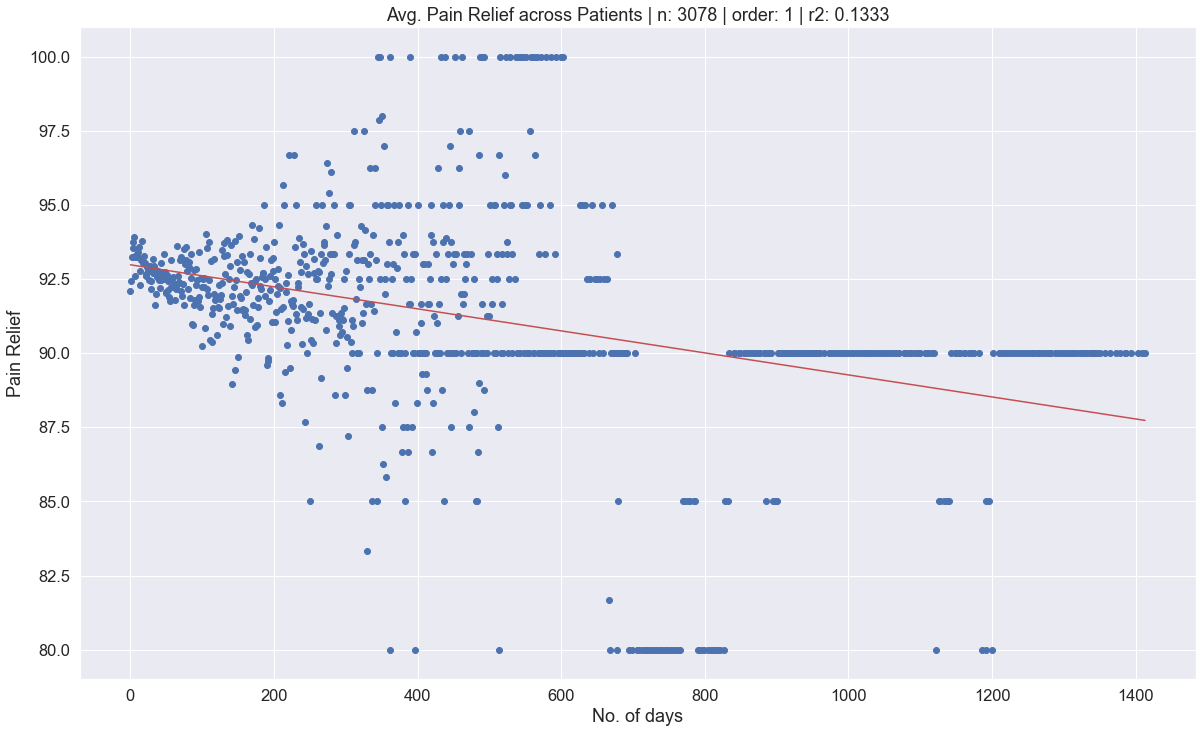

In [15]:
fig, ax = plt.subplots()
x = df_p1['hos_days']
y = df_p1['pain_relief']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y)
ax.plot(x, slope*x + intercept, color='r')
ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
plt.show()

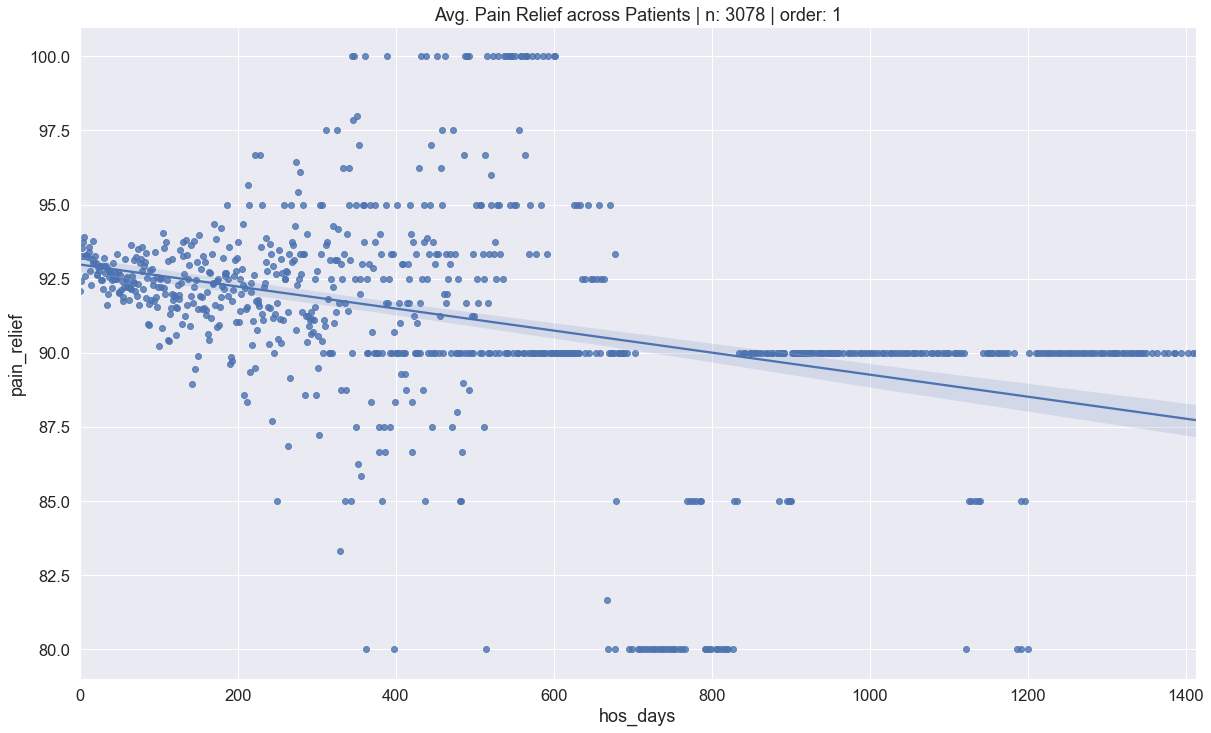

In [16]:
ax = plt.axes()
sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=1)
ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 1')
plt.show()

In [17]:
# normalized pain relief across all patients
df_p1 = df_pa[['IDEHR', 'hos_days', 'pain_relief']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()
df_p1

hos_days        IDEHR       pain_relief      
                     mean count        mean count
0          0  7984.399651   573   92.088424   573
1          1  7352.669989   903   92.440015   903
2          2  7512.532308   975   93.254701   975
3          3  7864.355388  1058   93.534972  1058
4          4  8074.698459  1038   93.754014  1038
..       ...          ...   ...         ...   ...
835     1386  6762.000000     1   90.000000     1
836     1394  6762.000000     1   90.000000     1
837     1403  6762.000000     1   90.000000     1
838     1409  6762.000000     1   90.000000     1
839     1413  6762.000000     1   90.000000     1

[840 rows x 5 columns]

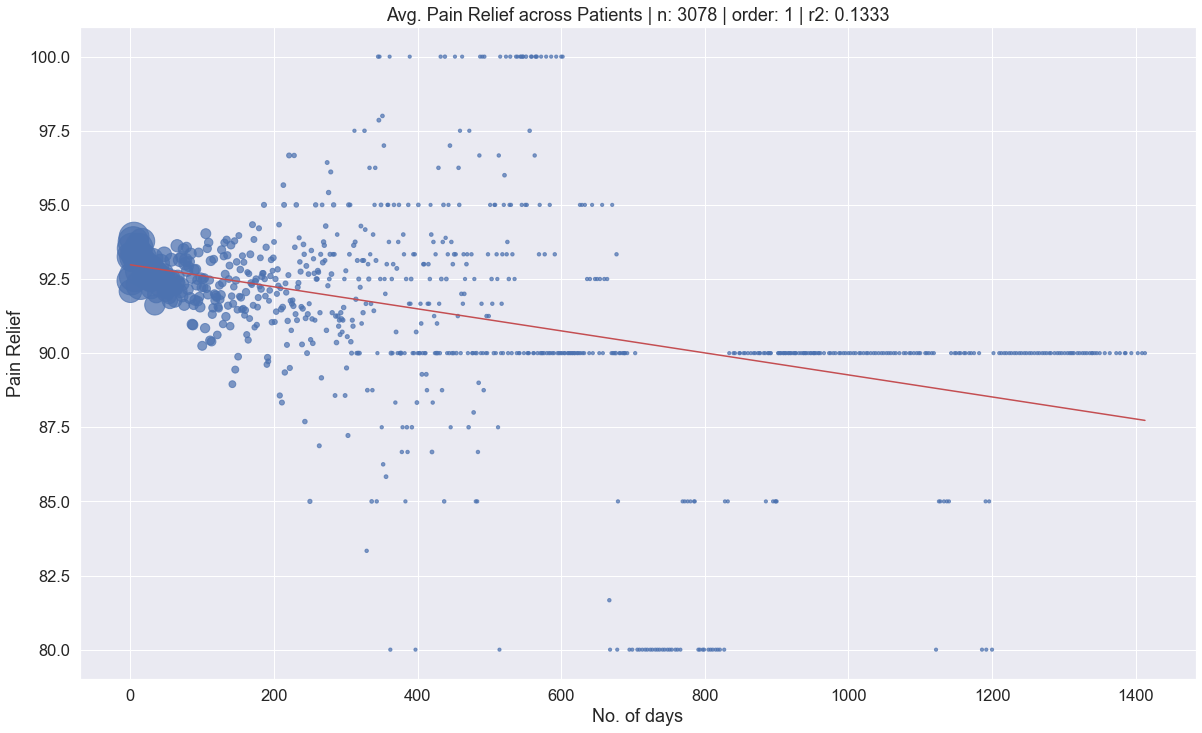

In [18]:
fig, ax = plt.subplots()
x = df_p1['hos_days']
y = df_p1['pain_relief']['mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y, s= get_scatter_marker_size(df_p1['IDEHR']['count']), alpha= 0.7)
ax.plot(x, slope*x + intercept, color='r')
ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
plt.savefig('./graphs/pain control/pain_avg.png', bbox_inches='tight')
plt.show()

In [19]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=2)
# ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 2')
# plt.show()

In [20]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=3)
# ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 3')
# plt.show()

In [21]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=4)
# ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 4')
# plt.show()

In [22]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=5)
# ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 5')
# plt.show()

In [23]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=7)
# ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 7')
# plt.show()

In [24]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p1, ax=ax, order=10)
# ax.set_title('Avg. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 10')
# plt.show()

In [25]:
# pain relief of patients surviving atleast x days
s_time = 30
df_p2 = df_pa[df_pa['survival_time_days'] >= s_time]
df_p2 = df_p2[df_p2['hos_days'] <= s_time]
p_num = len(df_p2.IDEHR.unique())
df_p2 = df_p2[['IDEHR', 'hos_days', 'pain_relief']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()

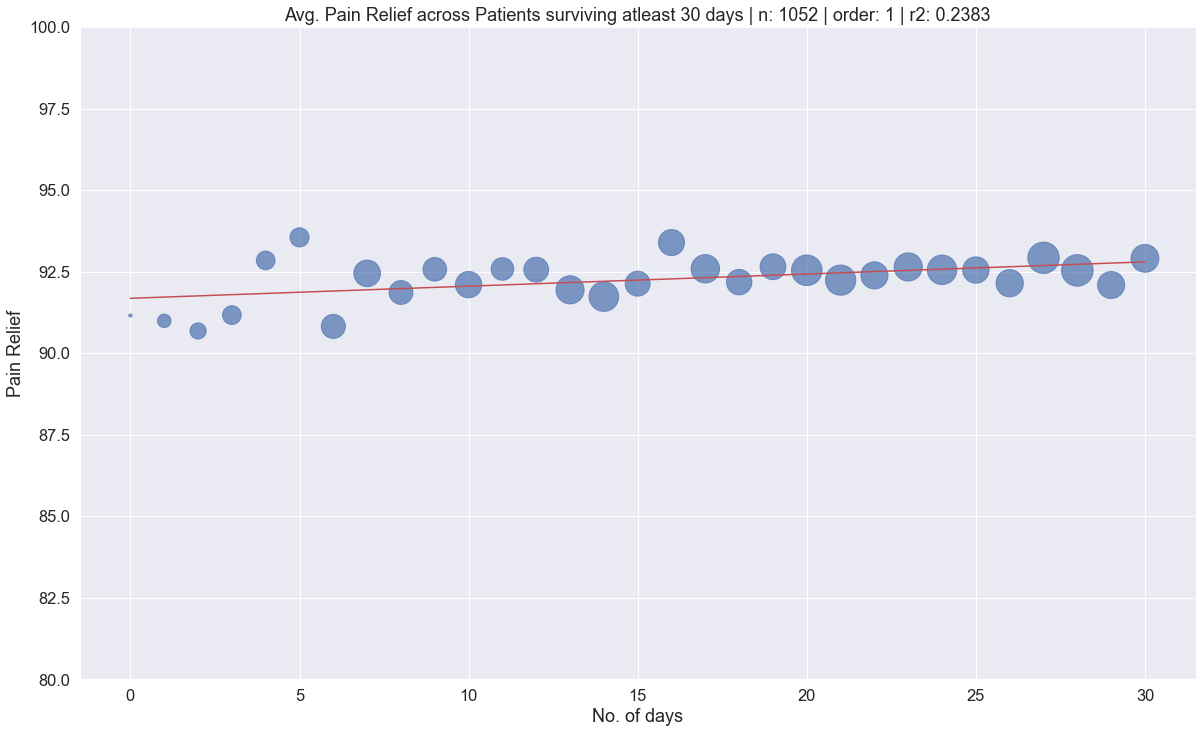

In [26]:
fig, ax = plt.subplots()
x = df_p2['hos_days']
y = df_p2['pain_relief']['mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y, s=get_scatter_marker_size(df_p2['IDEHR']['count']), alpha=0.7)
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Avg. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
ax.set(ylim=(80, 100))
plt.savefig('./graphs/pain control/pain_avg_f30.png', bbox_inches='tight')
plt.show()

In [27]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p2, ax=ax, order=2)
# ax.set_title('Avg. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 2')
# plt.show()

In [28]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p2, ax=ax, order=5)
# ax.set_title('Avg. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 3')
# plt.show()

In [29]:
# pain relief of patients surviving atleast x days
s_time = 60
df_p2 = df_pa[df_pa['survival_time_days'] >= s_time]
df_p2 = df_p2[df_p2['hos_days'] <= s_time]
p_num = len(df_p2.IDEHR.unique())
df_p2 = df_p2[['IDEHR', 'hos_days', 'pain_relief']].groupby(by=['hos_days']).agg(['mean', 'count']).reset_index()

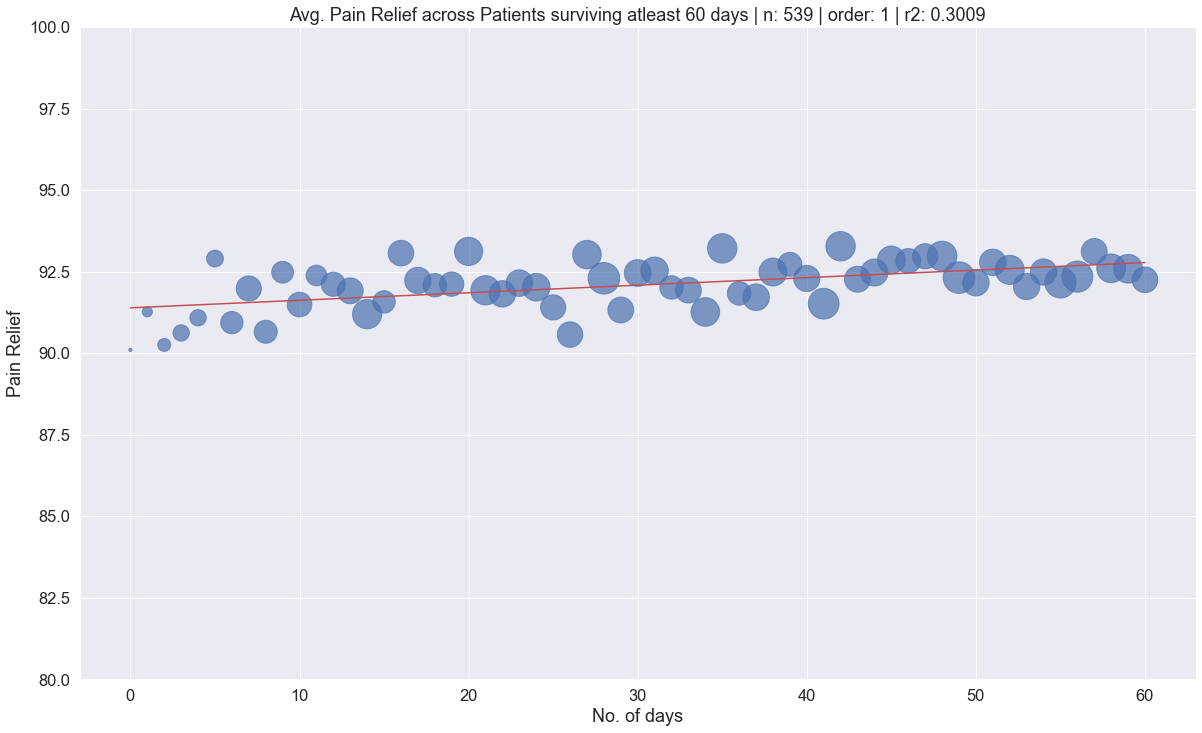

In [30]:
fig, ax = plt.subplots()
x = df_p2['hos_days']
y = df_p2['pain_relief']['mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y, s=get_scatter_marker_size(df_p2['IDEHR']['count']), alpha=0.7)
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set(ylim=(80,100))
ax.set_title('Avg. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
plt.savefig('./graphs/pain control/pain_avg_f60.png', bbox_inches='tight')
plt.show()

In [31]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p2, ax=ax, order=2)
# ax.set_title('Avg. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 2')
# plt.show()

In [32]:
# ax = plt.axes()
# sns.regplot(x='hos_days', y='pain_relief', data=df_p2, ax=ax, order=5)
# ax.set_title('Avg. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 3')
# plt.show()

In [33]:
# pain relief split by EHRType
df_p3 = df_pa[['IDEHR', 'EHRType', 'hos_days', 'pain_relief']].groupby(by=['EHRType', 'hos_days']).agg(['mean', 'count']).reset_index()
df_p3

EHRType hos_days         IDEHR       pain_relief      
                              mean count        mean count
0       AMB        0  14822.821862   247   88.562753   247
1       AMB        1  14796.300300   333   88.243243   333
2       AMB        2  15886.094395   339   87.050147   339
3       AMB        3  15654.706468   402   87.935323   402
4       AMB        4  15185.095794   428   88.656542   428
..      ...      ...           ...   ...         ...   ...
974     EHR      134   2597.500000     2  100.000000     2
975     EHR      135   2131.000000     1   90.000000     1
976     EHR      136   2131.000000     1  100.000000     1
977     EHR      137   2131.000000     1  100.000000     1
978     EHR      138   2131.000000     1  100.000000     1

[979 rows x 6 columns]

In [34]:
e_num = len(df_pa[df_pa['EHRType'] == 'EHR'].IDEHR.unique())
a_num = len(df_pa[df_pa['EHRType'] == 'AMB'].IDEHR.unique())
# sns.lmplot(x='hos_days', y='pain_relief', hue='EHRType', data=df_p3, order=1, height=10, aspect=1.8).fig.suptitle('Avg. Pain Relief across Patients by EHRType | n (EHR): ' + str(e_num) + ' | n (AMB): ' + str(a_num) + ' | order: 1')

In [35]:
df_pa[['EHRType', 'survival_time_days', 'hos_days']].groupby(by=['EHRType']).agg({'survival_time_days': [np.min, np.max, np.mean], 'hos_days': [np.min, np.max, np.mean]})

survival_time_days                     hos_days                 
                      amin    amax        mean     amin  amax       mean
EHRType                                                                 
AMB                    0.0  1416.0  148.442995        0  1413  77.681734
EHR                    0.0   476.0   37.425993        0   138  19.689937

In [36]:
# pain relief split by EHRType for first 200 days
df_p3 = df_p3[df_p3['hos_days'] <= 200]
# sns.lmplot(x='hos_days', y='pain_relief', hue='EHRType', data=df_p3, order=1, height=10, aspect=1.8).fig.suptitle('Avg. Pain Relief across Patients by EHRType | n (EHR): ' + str(e_num) + ' | n (AMB): ' + str(a_num) + ' | order: 1')

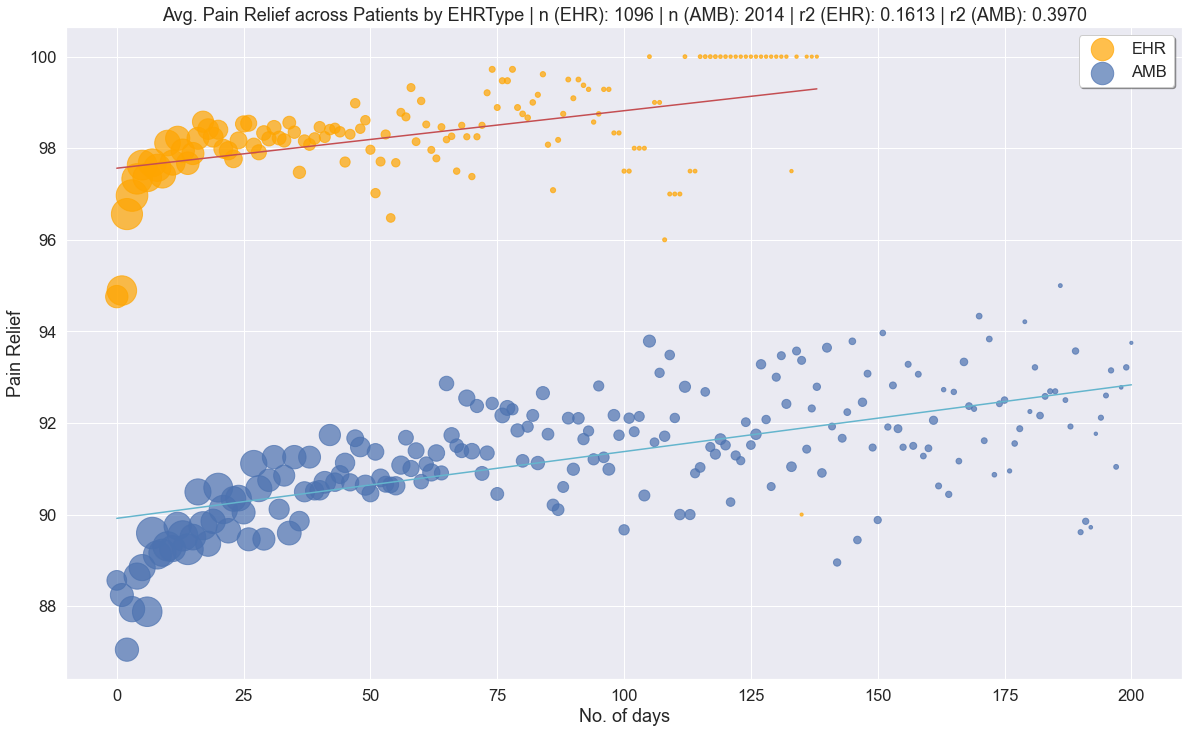

In [37]:
fig, ax = plt.subplots()
x_ehr = df_p3[df_p3['EHRType'] == 'EHR']['hos_days']
y_ehr = df_p3[df_p3['EHRType'] == 'EHR']['pain_relief']['mean']
slope, intercept, r_value_ehr, p_value, std_err = stats.linregress(x_ehr,y_ehr)
l1 = ax.scatter(x_ehr, y_ehr, color='orange', s=get_scatter_marker_size(df_p3[df_p3['EHRType'] == 'EHR']['IDEHR']['count']), alpha=0.7)
ax.plot(x_ehr, slope*x_ehr + intercept, color='r')
x_amb = df_p3[df_p3['EHRType'] == 'AMB']['hos_days']
y_amb = df_p3[df_p3['EHRType'] == 'AMB']['pain_relief']['mean']
slope, intercept, r_value_amb, p_value, std_err = stats.linregress(x_amb,y_amb)
l2 = ax.scatter(x_amb, y_amb, color='b', s=get_scatter_marker_size(df_p3[df_p3['EHRType'] == 'AMB']['IDEHR']['count']), alpha=0.7)
ax.plot(x_amb, slope*x_amb + intercept, color='c')
ax.legend((l1, l2), ('EHR', 'AMB'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Avg. Pain Relief across Patients by EHRType | n (EHR): ' + str(e_num) + ' | n (AMB): ' + str(a_num) + ' | r2 (EHR): ' + "{:.4f}".format(r_value_ehr ** 2) + " | r2 (AMB): " + "{:.4f}".format(r_value_amb ** 2))
plt.savefig('./graphs/pain control/pain_ehr.png', bbox_inches='tight')
plt.show()

[-8.75187332e-05  2.46324409e-02  9.72878843e+01]


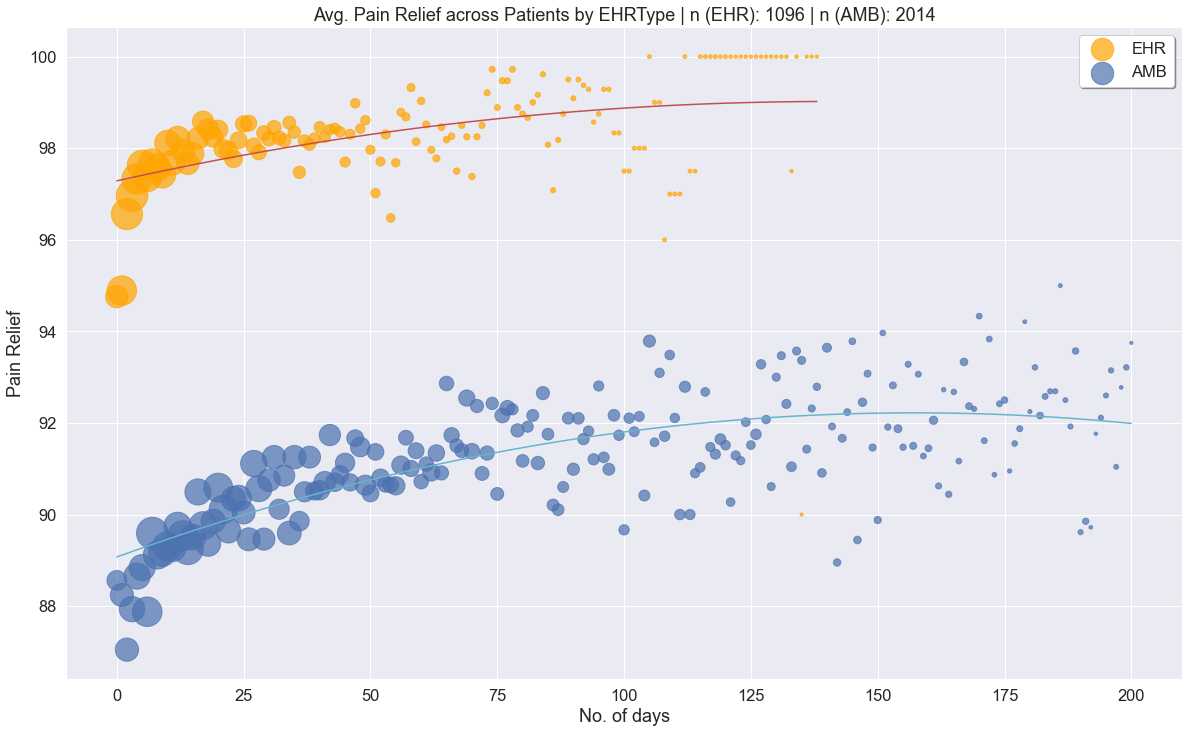

In [38]:
fig, ax = plt.subplots()
x_ehr = df_p3[df_p3['EHRType'] == 'EHR']['hos_days']
y_ehr = df_p3[df_p3['EHRType'] == 'EHR']['pain_relief']['mean']
coeffs = np.polyfit(x_ehr,y_ehr,deg=2)
print(coeffs)
l1 = ax.scatter(x_ehr, y_ehr, color='orange', s=get_scatter_marker_size(df_p3[df_p3['EHRType'] == 'EHR']['IDEHR']['count']), alpha=0.7)
ax.plot(x_ehr, coeffs[0]*x_ehr**2 + coeffs[1]*x_ehr + coeffs[2], color='r')
x_amb = df_p3[df_p3['EHRType'] == 'AMB']['hos_days']
y_amb = df_p3[df_p3['EHRType'] == 'AMB']['pain_relief']['mean']
coeffs = np.polyfit(x_amb,y_amb,deg=2)
l2 = ax.scatter(x_amb, y_amb, color='b', s=get_scatter_marker_size(df_p3[df_p3['EHRType'] == 'AMB']['IDEHR']['count']), alpha=0.7)
ax.plot(x_amb, coeffs[0]*x_amb**2 + coeffs[1]*x_amb + coeffs[2], color='c')
ax.legend((l1, l2), ('EHR', 'AMB'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Avg. Pain Relief across Patients by EHRType | n (EHR): ' + str(e_num) + ' | n (AMB): ' + str(a_num))
plt.savefig('./graphs/pain control/pain_ehr_2.png', bbox_inches='tight')
plt.show()

In [39]:
# pain relief split by setting
print(len(df_pa.IDEHR.unique()))
df_set = pd.read_excel('./vidas_data/IDEHR-EHRType-OU.xlsx')
df_set = df_set.rename(columns={"UO (Setting)\n": 'Setting'})
df_st = pd.merge(df_pa, df_set, on=['IDEHR', 'EHRType'])
print(len(df_st.IDEHR.unique()))
df_st

3078
3078


,IDEHR,EHRType,survival_time_days,Diagnosis,hos_days,pain_relief,PatientID,Setting
0,1375,EHR,476.0,Palliative (Non-Malignant),28,70.0,80,Hospice
1,1382,EHR,45.0,Palliative (Non-Malignant),28,90.0,30759,Hospice
2,1382,EHR,45.0,Palliative (Non-Malignant),29,100.0,30759,Hospice
3,1382,EHR,45.0,Palliative (Non-Malignant),30,100.0,30759,Hospice
4,1382,EHR,45.0,Palliative (Non-Malignant),31,100.0,30759,Hospice
...,...,...,...,...,...,...,...,...
45273,29090,AMB,20.0,GI Tract,17,90.0,59768,Domicilio
45274,29090,AMB,20.0,GI Tract,18,90.0,59768,Domicilio
45275,29147,AMB,3.0,Palliative (Non-Malignant),0,90.0,59800,Domicilio
45276,29258,AMB,8.0,Lung,5,80.0,59844,Domicilio


In [40]:
df_p5 = df_st[['IDEHR', 'Setting', 'hos_days', 'pain_relief']].groupby(by=['Setting', 'hos_days']).agg(['mean', 'count']).reset_index()
df_p5

Setting hos_days         IDEHR       pain_relief      
                                           mean count        mean count
0              Domicilio        0  14738.659836   244   88.483607   244
1              Domicilio        1  14737.773414   331   88.172205   331
2              Domicilio        2  15886.094395   339   87.050147   339
3              Domicilio        3  15654.706468   402   87.935323   402
4              Domicilio        4  15185.095794   428   88.656542   428
...                  ...      ...           ...   ...         ...   ...
1036  Hospice Pediatrico       18   3610.000000     1   86.666667     1
1037  Hospice Pediatrico       19   3610.000000     1   90.000000     1
1038  Hospice Pediatrico       20   3610.000000     1   90.000000     1
1039  Hospice Pediatrico       21   3610.000000     1   90.000000     1
1040  Hospice Pediatrico       22   3610.000000     1   95.000000     1

[1041 rows x 6 columns]

In [41]:
df_st[['Setting', 'survival_time_days', 'hos_days']].groupby(by=['Setting']).agg({'survival_time_days': [np.min, np.max, np.mean], 'hos_days': [np.min, np.max, np.mean]})

survival_time_days                     hos_days        \
                                   amin    amax        mean     amin  amax   
Setting                                                                      
Domicilio                           0.0  1416.0  148.527070        0  1413   
Domicilio Pediatrico                3.0   205.0   86.325581        0   194   
Hospice                             0.0   476.0   37.510664        0   138   
Hospice Pediatrico                  0.0    23.0   16.781818        0    22   

                                 
                           mean  
Setting                          
Domicilio             77.715140  
Domicilio Pediatrico  53.000000  
Hospice               19.734899  
Hospice Pediatrico     8.727273

In [42]:
df_st[['IDEHR', 'Setting']].groupby(by=['Setting']).agg(['nunique'])

,IDEHR
,nunique
Setting,
Domicilio,2005
Domicilio Pediatrico,9
Hospice,1091
Hospice Pediatrico,5


In [43]:
d_num = len(df_st[df_st['Setting'] == 'Domicilio'].IDEHR.unique())
dp_num = len(df_st[df_st['Setting'] == 'Domicilio Pediatrico'].IDEHR.unique())
h_num = len(df_st[df_st['Setting'] == 'Hospice'].IDEHR.unique())
hp_num = len(df_st[df_st['Setting'] == 'Hospice Pediatrico'].IDEHR.unique())
# sns.lmplot(x='hos_days', y='pain_relief', hue='Setting', data=df_p5, order=1, height=10, aspect=1.8).fig.suptitle('Avg. Pain Relief across Patients by Setting | n (D): ' + str(d_num) + ' | n (DP): ' + str(dp_num) + ' | n (H): ' + str(h_num) + ' | n (HP): ' + str(hp_num) + ' | order: 1')

In [44]:
# Setting for only first 200 days
df_p6 = df_p5[df_p5['hos_days'] <= 200]
# sns.lmplot(x='hos_days', y='pain_relief', hue='Setting', data=df_p6, order=1, height=10, aspect=1.8).fig.suptitle('Avg. Pain Relief across Patients by Setting | n (D): ' + str(d_num) + ' | n (DP): ' + str(dp_num) + ' | n (H): ' + str(h_num) + ' | n (HP): ' + str(hp_num) + ' | order: 1')

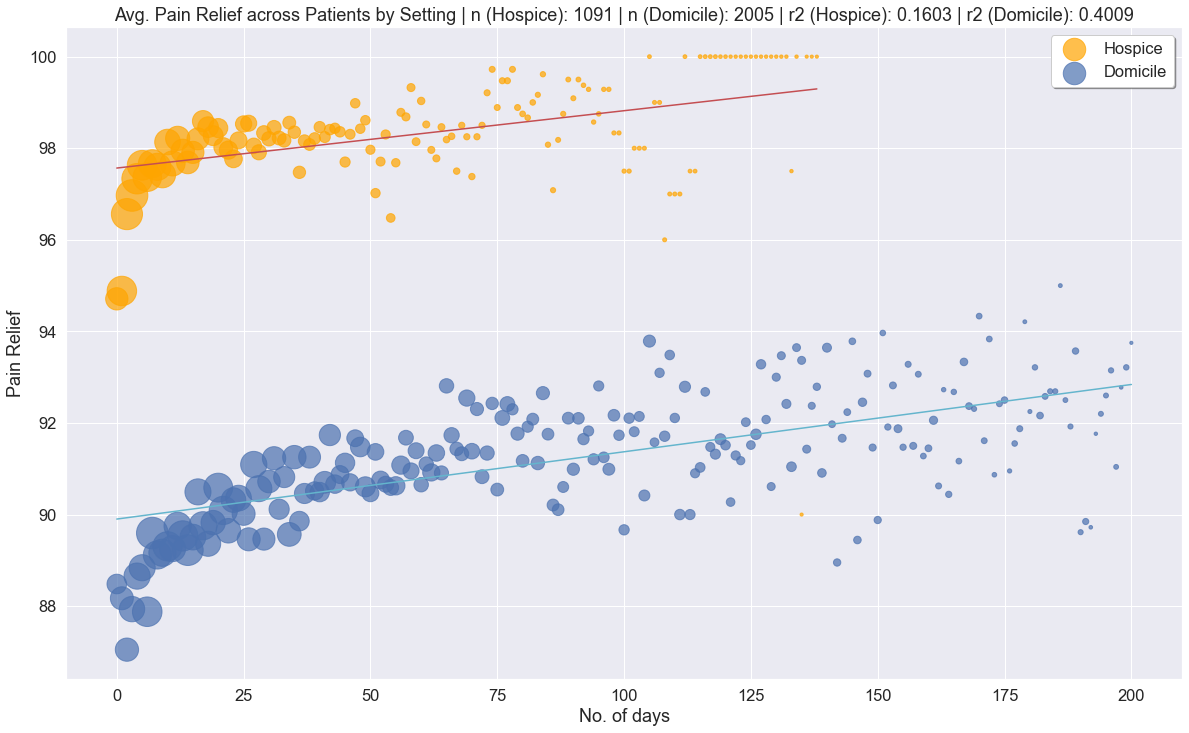

In [45]:
fig, ax = plt.subplots()
x_hos = df_p6[df_p6['Setting'] == 'Hospice']['hos_days']
y_hos = df_p6[df_p6['Setting'] == 'Hospice']['pain_relief']['mean']
slope, intercept, r_value_hos, p_value, std_err = stats.linregress(x_hos,y_hos)
l1 = ax.scatter(x_hos, y_hos, color='orange', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Hospice']['IDEHR']['count']), alpha=0.7)
ax.plot(x_hos, slope*x_hos + intercept, color='r')
x_dom = df_p6[df_p6['Setting'] == 'Domicilio']['hos_days']
y_dom = df_p6[df_p6['Setting'] == 'Domicilio']['pain_relief']['mean']
slope, intercept, r_value_dom, p_value, std_err = stats.linregress(x_dom,y_dom)
l2 = ax.scatter(x_dom, y_dom, color='b', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Domicilio']['IDEHR']['count']), alpha=0.7)
ax.plot(x_dom, slope*x_dom + intercept, color='c')
ax.legend((l1, l2), ('Hospice', 'Domicile'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Avg. Pain Relief across Patients by Setting | n (Hospice): ' + str(h_num) + ' | n (Domicile): ' + str(d_num) + ' | r2 (Hospice): ' + "{:.4f}".format(r_value_hos ** 2) + " | r2 (Domicile): " + "{:.4f}".format(r_value_dom ** 2))
plt.savefig('./graphs/pain control/pain_set.png', bbox_inches='tight')
plt.show()

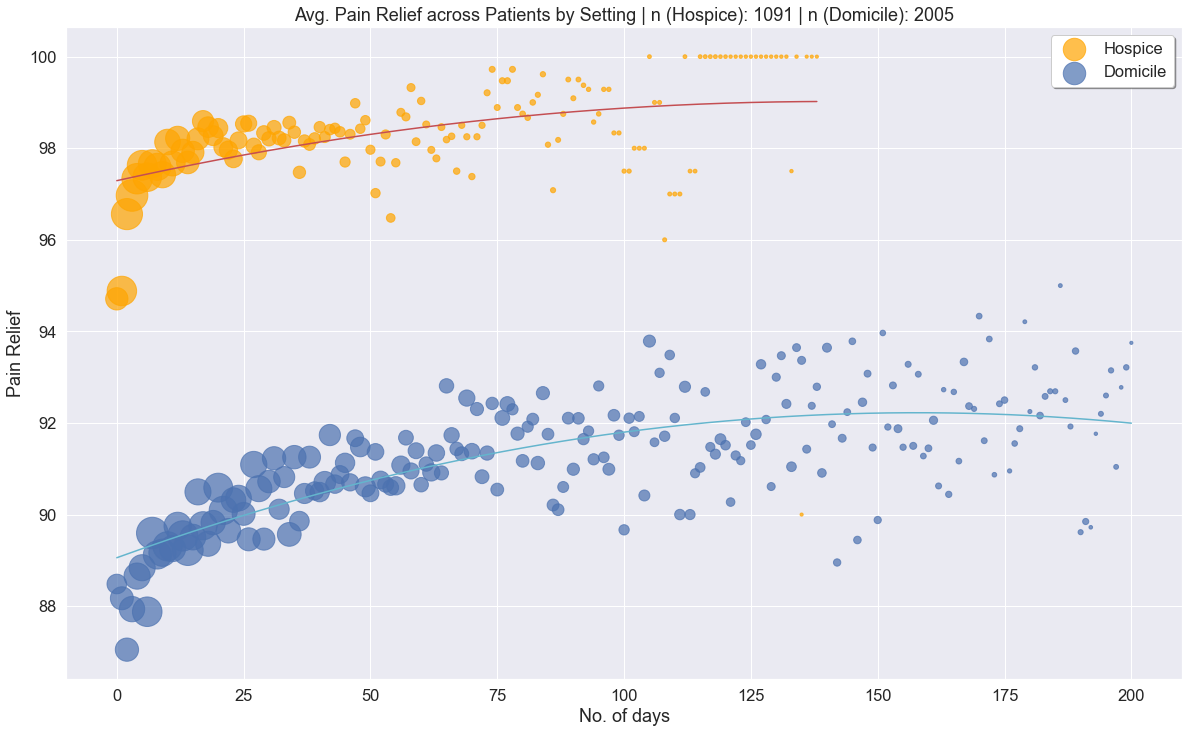

In [46]:
fig, ax = plt.subplots()
x_hos = df_p6[df_p6['Setting'] == 'Hospice']['hos_days']
y_hos = df_p6[df_p6['Setting'] == 'Hospice']['pain_relief']['mean']
coeffs = np.polyfit(x_hos,y_hos,deg=2)
l1 = ax.scatter(x_hos, y_hos, color='orange', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Hospice']['IDEHR']['count']), alpha=0.7)
ax.plot(x_hos, coeffs[0]*x_hos**2 + coeffs[1]*x_hos + coeffs[2], color='r')
x_dom = df_p6[df_p6['Setting'] == 'Domicilio']['hos_days']
y_dom = df_p6[df_p6['Setting'] == 'Domicilio']['pain_relief']['mean']
coeffs = np.polyfit(x_dom,y_dom,deg=2)
l2 = ax.scatter(x_dom, y_dom, color='b', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Domicilio']['IDEHR']['count']), alpha=0.7)
ax.plot(x_dom, coeffs[0]*x_dom**2 + coeffs[1]*x_dom + coeffs[2], color='c')
ax.legend((l1, l2), ('Hospice', 'Domicile'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Avg. Pain Relief across Patients by Setting | n (Hospice): ' + str(h_num) + ' | n (Domicile): ' + str(d_num))
plt.savefig('./graphs/pain control/pain_set_2.png', bbox_inches='tight')
plt.show()

In [47]:
# append the number of patients to each diagnosis name
d_label = df_pa[df_pa['hos_days'] <= 90][['IDEHR', 'Diagnosis']].drop_duplicates()['Diagnosis'].value_counts()
df_p4 = df_pa[['Diagnosis', 'hos_days', 'pain_relief']].groupby(by=['Diagnosis', 'hos_days']).mean().reset_index()
df_p4 = df_p4[df_p4['hos_days'] <= 90]
df_p4['Diagnosis'] = df_p4['Diagnosis'].apply(lambda x: np.nan if isinstance(x, float) else x + ' (n: ' + str(d_label[x]) + ')')
d_label

Lung                               636
GI Tract                           509
Pancreas                           334
Palliative (Non-Malignant)         261
Breast                             230
Liver-Biliary                      217
Genitourinary                      172
Cervical-Ovarian                   157
Prostate                           125
Brain-Snc                           86
Lymphoma                            70
Head-Neck                           67
Sarcoma                             63
Skin                                46
Myeloid Leukemia                    38
Palliative (Cancer-Unspecified)     22
Thyroid                             11
Lymphoid_Leukemia                   10
Name: Diagnosis, dtype: int64

In [48]:
print(df_pa[df_pa['hos_days'] <= 90][['IDEHR', 'Diagnosis']].groupby(by=['Diagnosis']).nunique().stack().sum())
df_pa[df_pa['hos_days'] <= 90][['IDEHR', 'Diagnosis']].groupby(by=['Diagnosis']).nunique().stack()

3054


Diagnosis                             
Brain-Snc                        IDEHR     86
Breast                           IDEHR    230
Cervical-Ovarian                 IDEHR    157
GI Tract                         IDEHR    509
Genitourinary                    IDEHR    172
Head-Neck                        IDEHR     67
Liver-Biliary                    IDEHR    217
Lung                             IDEHR    636
Lymphoid_Leukemia                IDEHR     10
Lymphoma                         IDEHR     70
Myeloid Leukemia                 IDEHR     38
Palliative (Cancer-Unspecified)  IDEHR     22
Palliative (Non-Malignant)       IDEHR    261
Pancreas                         IDEHR    334
Prostate                         IDEHR    125
Sarcoma                          IDEHR     63
Skin                             IDEHR     46
Thyroid                          IDEHR     11
dtype: int64

In [49]:
# heatmaps of avg pain relief across diagnosis
d_label = df_pa[df_pa['hos_days'] <= 90][['IDEHR', 'Diagnosis']].groupby(by=['Diagnosis']).nunique().stack()
df_p4 = df_pa[['Diagnosis', 'hos_days', 'pain_relief']].groupby(by=['Diagnosis', 'hos_days']).mean().reset_index()
df_p4 = df_p4[df_p4['hos_days'] <= 90]
df_p4['Diagnosis'] = df_p4['Diagnosis'].apply(lambda x: np.nan if isinstance(x, float) else x + ' (n: ' + str(d_label[x][0]) + ')')
p_num = d_label.sum()
df_p4 = df_p4.pivot(index='Diagnosis', columns='hos_days', values='pain_relief')
df_p4

hos_days,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 86),96.538462,96.304348,96.041667,95.192308,96.419753,96.923077,94.833333,96.612903,97.407407,95.238095,...,100.000000,97.500000,96.000000,96.666667,97.000000,90.000000,95.000000,100.000000,97.500000,95.000000
Breast (n: 230),93.214286,92.602740,93.125000,94.144737,96.266667,94.718876,92.839506,93.855422,92.012987,92.816901,...,96.250000,95.833333,90.000000,98.333333,92.727273,91.666667,90.000000,92.142857,96.111111,91.111111
Cervical-Ovarian (n: 157),91.034483,92.553191,95.784314,94.435484,94.062500,94.926471,96.067708,94.375000,94.591837,91.792453,...,86.000000,92.222222,90.000000,87.500000,86.666667,80.000000,84.000000,92.000000,90.000000,83.750000
GI Tract (n: 509),91.647727,91.655844,92.525562,92.748538,93.302469,93.424242,92.071006,92.460317,93.888889,93.647799,...,94.210526,95.576923,92.000000,92.777778,93.055556,91.000000,92.291667,91.875000,92.857143,92.750000
Genitourinary (n: 172),90.892857,93.958333,92.457627,95.983607,94.538462,95.546875,92.628205,93.513514,96.048387,91.615385,...,91.000000,97.500000,90.909091,95.555556,90.000000,90.555556,92.777778,91.666667,93.571429,92.727273
Head-Neck (n: 67),91.944444,94.133333,94.843750,93.440860,90.555556,97.954545,95.166667,95.192308,94.615385,94.400000,...,90.000000,90.000000,100.000000,100.000000,90.000000,NaN,90.000000,90.000000,90.000000,NaN
Liver-Biliary (n: 217),93.055556,91.564103,95.204678,94.687500,94.076923,94.328358,93.164557,93.684211,93.823529,94.558824,...,93.000000,91.666667,91.363636,94.375000,91.250000,90.833333,92.500000,100.000000,88.750000,88.571429
Lung (n: 636),91.067708,91.888889,92.727273,91.732026,92.663399,92.500000,91.600985,92.551170,91.666667,92.832370,...,93.260870,90.238095,91.956522,92.500000,92.000000,90.000000,92.142857,92.105263,88.888889,92.500000
Lymphoid_Leukemia (n: 10),100.000000,100.000000,100.000000,100.000000,96.666667,93.333333,95.000000,95.000000,98.750000,95.000000,...,NaN,85.000000,NaN,90.000000,90.000000,NaN,NaN,90.000000,90.000000,NaN


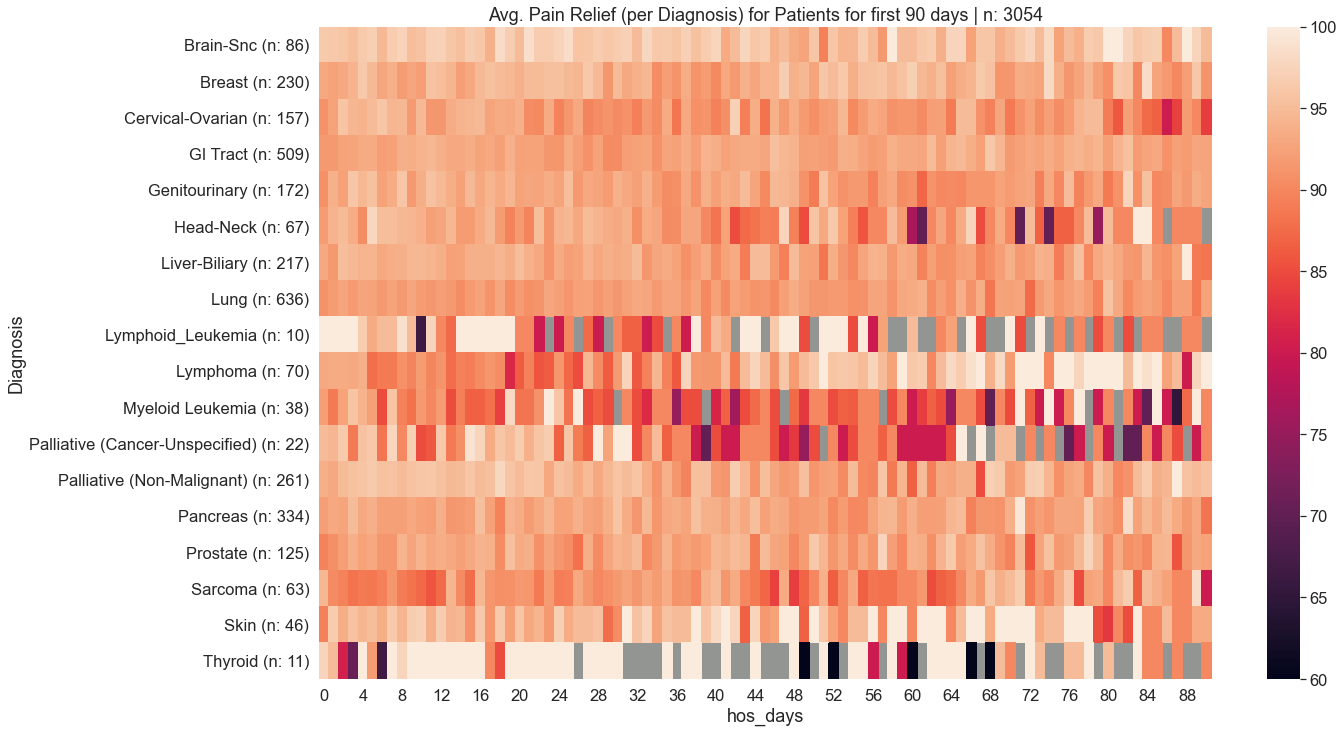

In [50]:
ax = plt.axes()
sns.heatmap(df_p4, annot=False, fmt='g', ax=ax, xticklabels=4)
ax.set_facecolor('xkcd:gray')
ax.set_title('Avg. Pain Relief (per Diagnosis) for Patients for first 90 days | n: ' + str(p_num))
plt.savefig('./graphs/pain control/pain_heatmap_f90.png', bbox_inches='tight')
plt.show()

In [51]:
n = 90
dft = df_p4.apply(lambda x: np.polyfit(y=x, x=np.linspace(0, n, n+1), deg=1) if np.sum(np.isfinite(x)) == n+1 else 'undef', axis=1)
dft = dft.to_frame().rename(columns={0: 'deg1 (m)'})
dft['deg1 (m)'] = dft['deg1 (m)'].apply(lambda x: x if isinstance(x, str) else np.round(x[0], 2))
dft_2 = df_p4.apply(lambda x: np.polyfit(y=x, x=np.linspace(0, n, n+1) , deg=2) if np.sum(np.isfinite(x)) == n+1 else 'undef', axis=1).to_frame().rename(columns={0: 'deg2'})
dft_2 = dft_2['deg2'].apply(lambda x: ['undef', 'undef'] if isinstance(x, str) else x[0:2])
dft_2 = pd.DataFrame(dft_2.to_list(), columns=['deg2 (x2)', 'deg2 (x1)'], index=dft_2.index)
dft = pd.concat([dft, dft_2], axis=1)
dft['deg2 (x2)'] = dft['deg2 (x2)'].apply(lambda x: np.round(x, 2) if isinstance(x, float) else x)
dft['deg2 (x1)'] = dft['deg2 (x1)'].apply(lambda x: np.round(x, 2) if isinstance(x, float) else x)
# dft

In [52]:
get_coeffs(df_p4, 90)

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,deg1 (m),deg2 (x2),deg2 (x1)
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 86),96.538462,96.304348,96.041667,95.192308,96.419753,96.923077,94.833333,96.612903,97.407407,95.238095,...,96.666667,97.000000,90.000000,95.000000,100.000000,97.500000,95.000000,-0.01,0,-0.05
Breast (n: 230),93.214286,92.602740,93.125000,94.144737,96.266667,94.718876,92.839506,93.855422,92.012987,92.816901,...,98.333333,92.727273,91.666667,90.000000,92.142857,96.111111,91.111111,-0,-0,0.03
Cervical-Ovarian (n: 157),91.034483,92.553191,95.784314,94.435484,94.062500,94.926471,96.067708,94.375000,94.591837,91.792453,...,87.500000,86.666667,80.000000,84.000000,92.000000,90.000000,83.750000,-0.05,-0,-0.01
GI Tract (n: 509),91.647727,91.655844,92.525562,92.748538,93.302469,93.424242,92.071006,92.460317,93.888889,93.647799,...,92.777778,93.055556,91.000000,92.291667,91.875000,92.857143,92.750000,0.01,-0,0.01
Genitourinary (n: 172),90.892857,93.958333,92.457627,95.983607,94.538462,95.546875,92.628205,93.513514,96.048387,91.615385,...,95.555556,90.000000,90.555556,92.777778,91.666667,93.571429,92.727273,-0.03,0,-0.08
Head-Neck (n: 67),91.944444,94.133333,94.843750,93.440860,90.555556,97.954545,95.166667,95.192308,94.615385,94.400000,...,100.000000,90.000000,NaN,90.000000,90.000000,90.000000,NaN,undef,undef,undef
Liver-Biliary (n: 217),93.055556,91.564103,95.204678,94.687500,94.076923,94.328358,93.164557,93.684211,93.823529,94.558824,...,94.375000,91.250000,90.833333,92.500000,100.000000,88.750000,88.571429,-0.02,0,-0.06
Lung (n: 636),91.067708,91.888889,92.727273,91.732026,92.663399,92.500000,91.600985,92.551170,91.666667,92.832370,...,92.500000,92.000000,90.000000,92.142857,92.105263,88.888889,92.500000,-0,-0,0.01
Lymphoid_Leukemia (n: 10),100.000000,100.000000,100.000000,100.000000,96.666667,93.333333,95.000000,95.000000,98.750000,95.000000,...,90.000000,90.000000,NaN,NaN,90.000000,90.000000,NaN,undef,undef,undef


In [53]:
s_time = 90
df_p6 = df_pa[df_pa['survival_time_days'] >= s_time]
df_p6 = df_p6[df_p6['hos_days'] <= s_time]
d_label = df_p6[df_p6['hos_days'] <= s_time][['IDEHR', 'Diagnosis']].groupby(by=['Diagnosis']).nunique().stack()
p_num = d_label.sum()
df_p6 = df_p6[['Diagnosis', 'hos_days', 'pain_relief']].groupby(by=['Diagnosis', 'hos_days']).mean().reset_index()
df_p6 = df_p6[df_p6['hos_days'] <= s_time]
df_p6['Diagnosis'] = df_p6['Diagnosis'].apply(lambda x: np.nan if isinstance(x, float) else x + ' (n: ' + str(d_label[x][0]) + ')')
df_p6 = df_p6.pivot(index='Diagnosis', columns='hos_days', values='pain_relief')
df_p6

hos_days,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 12),NaN,90.000000,100.000000,NaN,NaN,100.000000,95.000000,95.000000,93.333333,90.000000,...,100.000000,97.500000,96.000000,96.666667,97.000000,90.000000,95.000000,100.000000,97.500000,95.000000
Breast (n: 26),60.000000,80.000000,90.000000,94.166667,93.333333,88.333333,90.000000,92.500000,85.000000,93.571429,...,96.250000,95.833333,90.000000,98.333333,93.500000,92.727273,90.000000,92.142857,96.111111,91.111111
Cervical-Ovarian (n: 15),NaN,90.000000,97.500000,90.000000,90.000000,95.000000,95.000000,92.500000,96.666667,95.714286,...,86.000000,91.250000,90.000000,87.500000,86.666667,80.000000,84.000000,92.000000,90.000000,83.750000
GI Tract (n: 53),83.333333,90.000000,81.000000,87.500000,78.125000,90.000000,85.555556,90.277778,90.769231,84.000000,...,94.375000,95.217391,93.043478,92.500000,93.437500,90.555556,92.045455,91.428571,92.857143,92.750000
Genitourinary (n: 24),NaN,95.000000,90.000000,87.500000,90.000000,93.750000,92.500000,90.357143,96.666667,92.500000,...,91.000000,97.500000,90.909091,95.555556,90.000000,90.555556,92.777778,91.666667,93.571429,92.727273
Head-Neck (n: 4),NaN,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,90.000000,90.000000,NaN,NaN,90.000000,NaN,90.000000,90.000000,90.000000,NaN
Liver-Biliary (n: 17),90.000000,60.000000,90.000000,92.500000,85.000000,90.000000,90.000000,90.000000,90.000000,95.000000,...,91.250000,87.500000,90.555556,93.571429,90.000000,90.833333,92.500000,100.000000,88.750000,88.571429
Lung (n: 62),92.857143,96.000000,98.333333,83.181818,91.250000,89.375000,90.000000,92.500000,88.461538,90.714286,...,93.947368,91.000000,91.956522,92.608696,93.055556,91.333333,92.142857,93.235294,88.888889,92.500000
Lymphoid_Leukemia (n: 3),100.000000,100.000000,NaN,100.000000,100.000000,90.000000,90.000000,NaN,100.000000,90.000000,...,NaN,85.000000,NaN,90.000000,90.000000,NaN,NaN,90.000000,90.000000,NaN


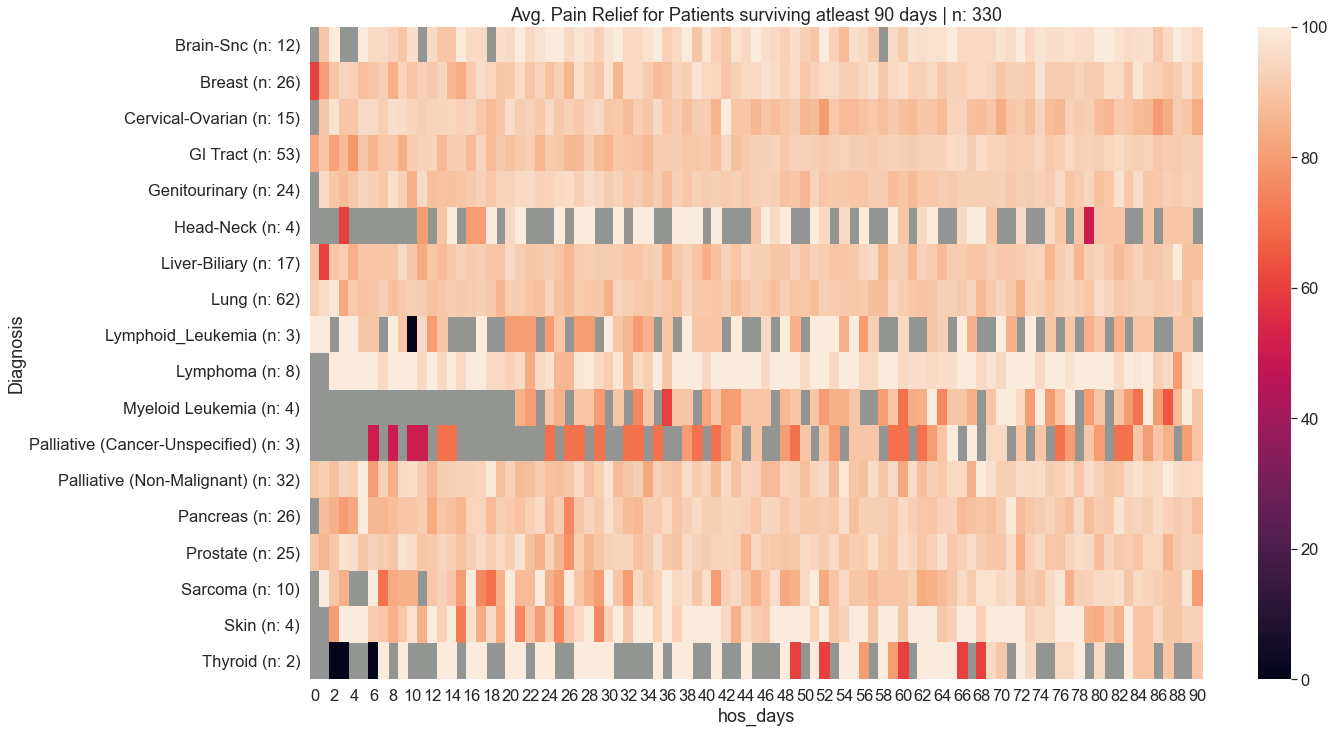

In [54]:
ax = plt.axes()
sns.heatmap(df_p6, annot=False, fmt='.2g', ax=ax)
ax.set_facecolor('xkcd:gray')
ax.set_title('Avg. Pain Relief for Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num))
plt.savefig('./graphs/pain control/pain_heatmap_a90.png', bbox_inches='tight')
plt.show()

In [55]:
get_coeffs(df_p6, 90)

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,deg1 (m),deg2 (x2),deg2 (x1)
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 12),NaN,90.000000,100.000000,NaN,NaN,100.000000,95.000000,95.000000,93.333333,90.000000,...,96.666667,97.000000,90.000000,95.000000,100.000000,97.500000,95.000000,undef,undef,undef
Breast (n: 26),60.000000,80.000000,90.000000,94.166667,93.333333,88.333333,90.000000,92.500000,85.000000,93.571429,...,98.333333,93.500000,92.727273,90.000000,92.142857,96.111111,91.111111,0.06,-0,0.3
Cervical-Ovarian (n: 15),NaN,90.000000,97.500000,90.000000,90.000000,95.000000,95.000000,92.500000,96.666667,95.714286,...,87.500000,86.666667,80.000000,84.000000,92.000000,90.000000,83.750000,undef,undef,undef
GI Tract (n: 53),83.333333,90.000000,81.000000,87.500000,78.125000,90.000000,85.555556,90.277778,90.769231,84.000000,...,92.500000,93.437500,90.555556,92.045455,91.428571,92.857143,92.750000,0.07,-0,0.17
Genitourinary (n: 24),NaN,95.000000,90.000000,87.500000,90.000000,93.750000,92.500000,90.357143,96.666667,92.500000,...,95.555556,90.000000,90.555556,92.777778,91.666667,93.571429,92.727273,undef,undef,undef
Head-Neck (n: 4),NaN,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,90.000000,NaN,90.000000,90.000000,90.000000,NaN,undef,undef,undef
Liver-Biliary (n: 17),90.000000,60.000000,90.000000,92.500000,85.000000,90.000000,90.000000,90.000000,90.000000,95.000000,...,93.571429,90.000000,90.833333,92.500000,100.000000,88.750000,88.571429,0.04,-0,0.15
Lung (n: 62),92.857143,96.000000,98.333333,83.181818,91.250000,89.375000,90.000000,92.500000,88.461538,90.714286,...,92.608696,93.055556,91.333333,92.142857,93.235294,88.888889,92.500000,0.01,0,-0.06
Lymphoid_Leukemia (n: 3),100.000000,100.000000,NaN,100.000000,100.000000,90.000000,90.000000,NaN,100.000000,90.000000,...,90.000000,90.000000,NaN,NaN,90.000000,90.000000,NaN,undef,undef,undef


## Min. Pain Relief (Worst-case) ##

In [56]:
df_p1 = df_pa[['IDEHR', 'hos_days', 'pain_relief']].groupby(by=['hos_days']).agg(['min', 'count']).reset_index()
df_p1

hos_days IDEHR       pain_relief      
               min count         min count
0          0  1414   573        30.0   573
1          1  1414   903         0.0   903
2          2  1414   975         0.0   975
3          3  1421  1058         0.0  1058
4          4  1421  1038         0.0  1038
..       ...   ...   ...         ...   ...
835     1386  6762     1        90.0     1
836     1394  6762     1        90.0     1
837     1403  6762     1        90.0     1
838     1409  6762     1        90.0     1
839     1413  6762     1        90.0     1

[840 rows x 5 columns]

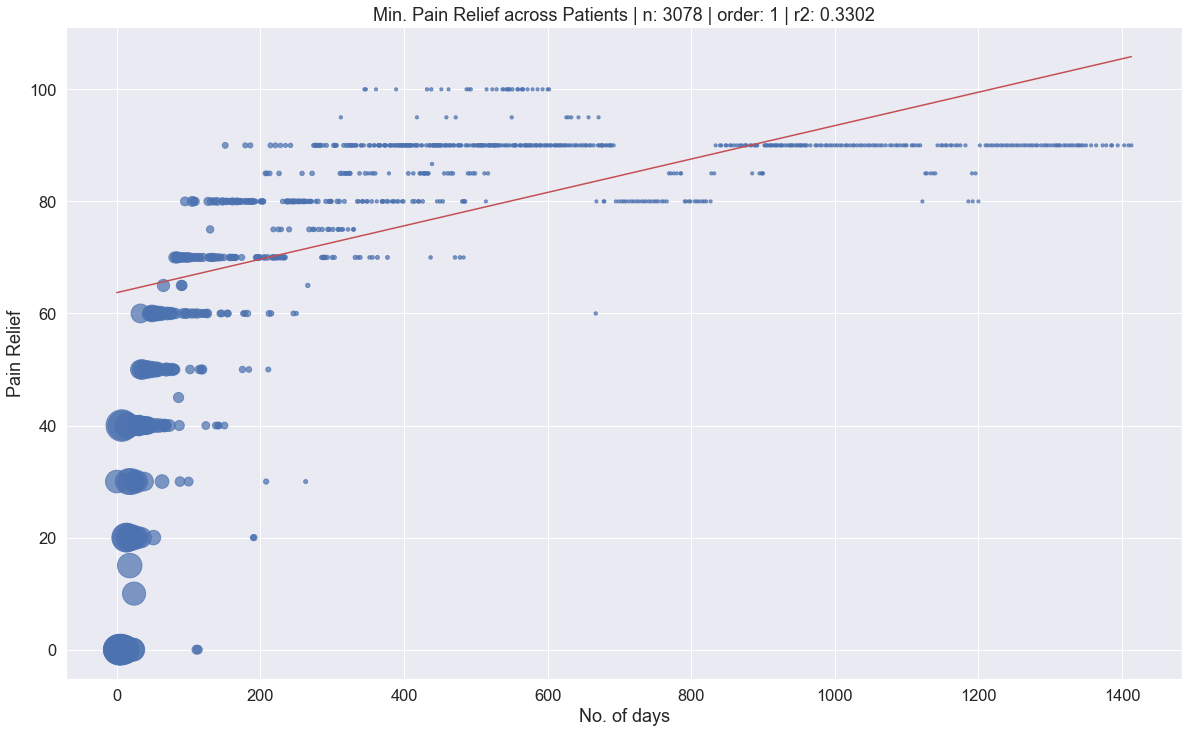

In [57]:
fig, ax = plt.subplots()
x = df_p1['hos_days']
y = df_p1['pain_relief']['min']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y, s=get_scatter_marker_size(df_p1['IDEHR']['count']), alpha=0.7)
ax.plot(x, slope*x + intercept, color='r')
ax.set_title('Min. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
plt.savefig('./graphs/pain control/pain_min.png', bbox_inches='tight')
plt.show()

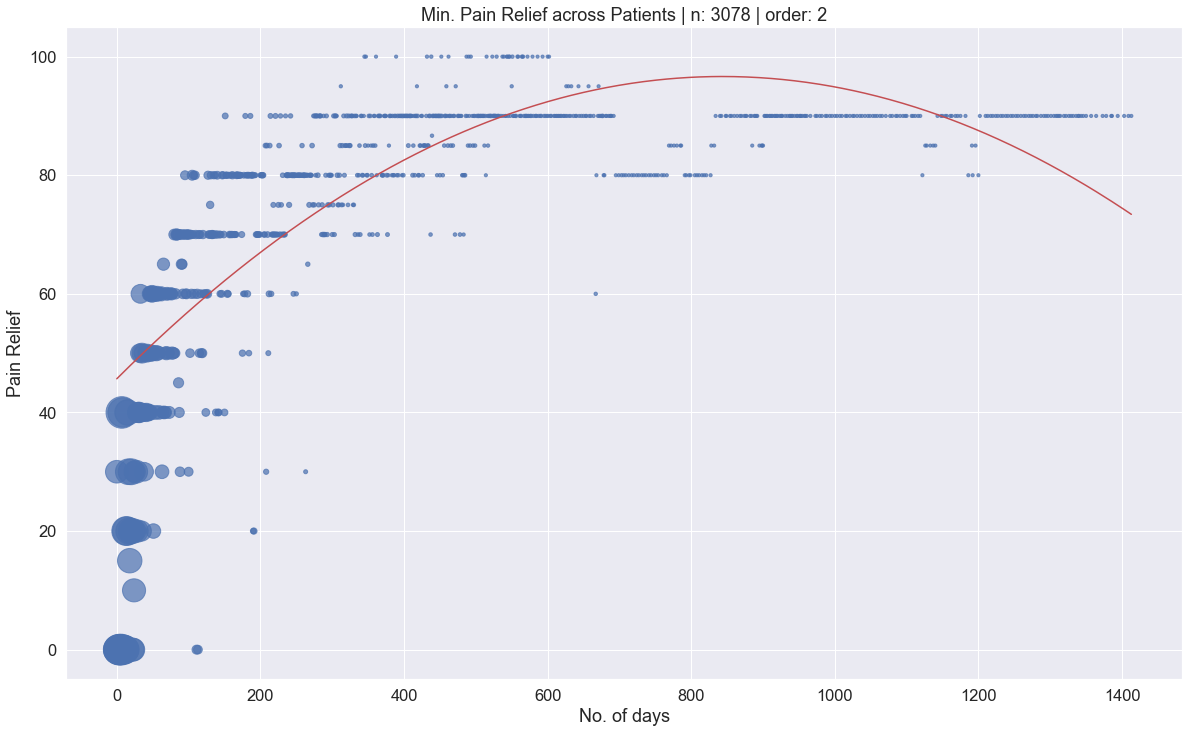

In [58]:
fig, ax = plt.subplots()
x = df_p1['hos_days']
y = df_p1['pain_relief']['min']
coeffs = np.polyfit(x,y,deg=2)
ax.scatter(x, y, s=get_scatter_marker_size(df_p1['IDEHR']['count']), alpha=0.7)
ax.plot(x, coeffs[0]*x**2 + coeffs[1]*x + coeffs[2], color='r')
ax.set_title('Min. Pain Relief across Patients | n: ' + str(len(df_pa.IDEHR.unique())) + ' | order: 2')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
plt.savefig('./graphs/pain control/pain_min_2.png', bbox_inches='tight')
plt.show()

In [59]:
# pain relief of patients surviving atleast x days
s_time = 30
df_p2 = df_pa[df_pa['survival_time_days'] >= s_time]
df_p2 = df_p2[df_p2['hos_days'] <= s_time]
p_num = len(df_p2.IDEHR.unique())
df_p2 = df_p2[['IDEHR', 'hos_days', 'pain_relief']].groupby(by=['hos_days']).agg(['min', 'count']).reset_index()

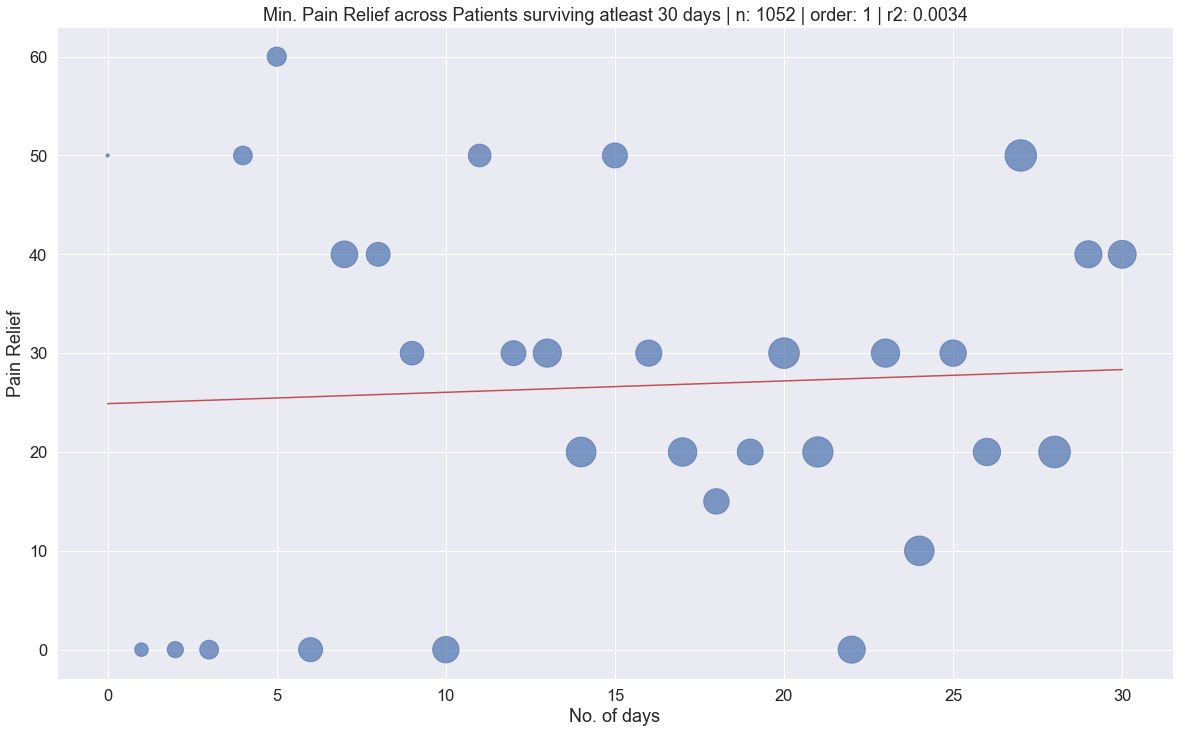

In [60]:
fig, ax = plt.subplots()
x = df_p2['hos_days']
y = df_p2['pain_relief']['min']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y, s=get_scatter_marker_size(df_p2['IDEHR']['count']), alpha=0.7)
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Min. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
plt.savefig('./graphs/pain control/pain_minim_a30.png', bbox_inches='tight')
plt.show()

In [61]:
s_time = 60
df_p2 = df_pa[df_pa['survival_time_days'] >= s_time]
df_p2 = df_p2[df_p2['hos_days'] <= s_time]
p_num = len(df_p2.IDEHR.unique())
df_p2 = df_p2[['IDEHR', 'hos_days', 'pain_relief']].groupby(by=['hos_days']).agg(['min', 'count']).reset_index()

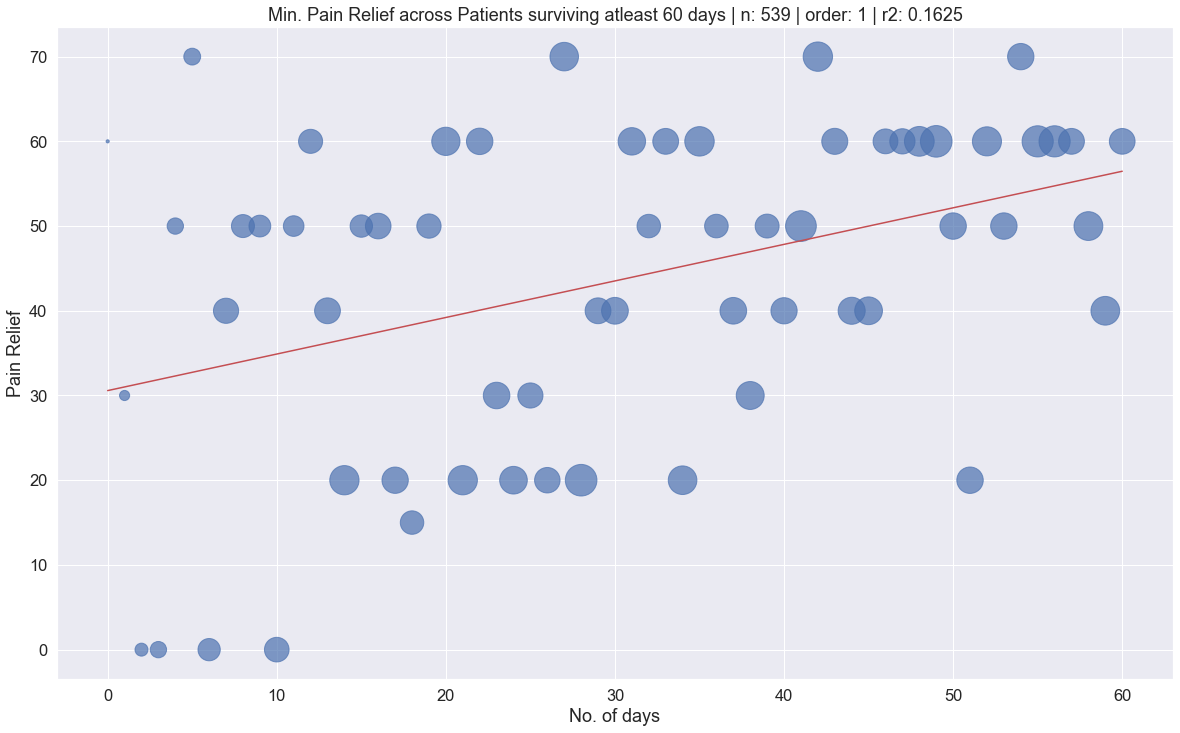

In [62]:
fig, ax = plt.subplots()
x = df_p2['hos_days']
y = df_p2['pain_relief']['min']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.scatter(x, y, s=get_scatter_marker_size(df_p2['IDEHR']['count']), alpha=0.7)
ax.plot(x, slope*x + intercept, color='r')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Min. Pain Relief across Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num) + ' | order: 1 | r2: ' + "{:.4f}".format(r_value ** 2))
plt.savefig('./graphs/pain control/pain_min_a60.png', bbox_inches='tight')
plt.show()

In [63]:
# pain relief split by EHRType
df_p3 = df_pa[['IDEHR', 'EHRType', 'hos_days', 'pain_relief']].groupby(by=['EHRType', 'hos_days']).agg(['min', 'count']).reset_index()
df_p3

EHRType hos_days IDEHR       pain_relief      
                       min count         min count
0       AMB        0  1760   247        30.0   247
1       AMB        1  3453   333         0.0   333
2       AMB        2  3417   339         0.0   339
3       AMB        3  1760   402         0.0   402
4       AMB        4  3453   428         0.0   428
..      ...      ...   ...   ...         ...   ...
974     EHR      134  2131     2       100.0     2
975     EHR      135  2131     1        90.0     1
976     EHR      136  2131     1       100.0     1
977     EHR      137  2131     1       100.0     1
978     EHR      138  2131     1       100.0     1

[979 rows x 6 columns]

In [64]:
e_num = len(df_pa[df_pa['EHRType'] == 'EHR'].IDEHR.unique())
a_num = len(df_pa[df_pa['EHRType'] == 'AMB'].IDEHR.unique())
df_p3 = df_p3[df_p3['hos_days'] <= 200]

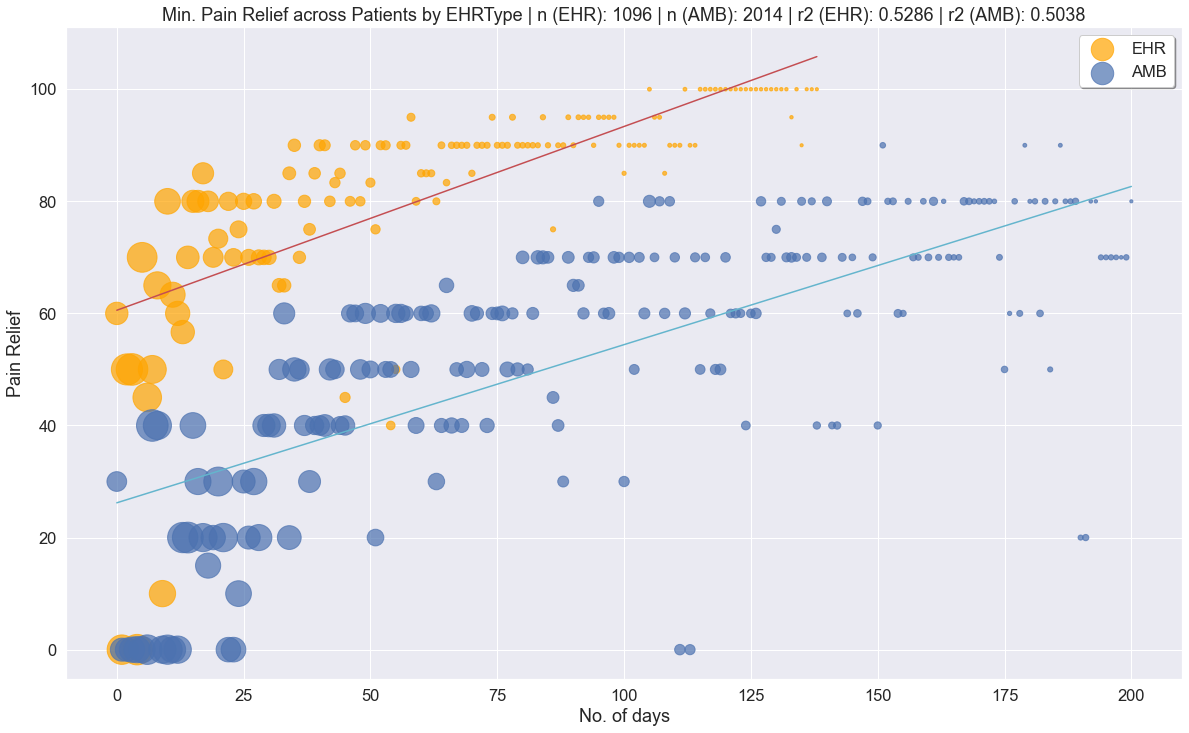

In [65]:
fig, ax = plt.subplots()
x_ehr = df_p3[df_p3['EHRType'] == 'EHR']['hos_days']
y_ehr = df_p3[df_p3['EHRType'] == 'EHR']['pain_relief']['min']
slope, intercept, r_value_ehr, p_value, std_err = stats.linregress(x_ehr,y_ehr)
l1 = ax.scatter(x_ehr, y_ehr, color='orange', s=get_scatter_marker_size(df_p3[df_p3['EHRType']=='EHR']['IDEHR']['count']), alpha=0.7)
ax.plot(x_ehr, slope*x_ehr + intercept, color='r')
x_amb = df_p3[df_p3['EHRType'] == 'AMB']['hos_days']
y_amb = df_p3[df_p3['EHRType'] == 'AMB']['pain_relief']['min']
slope, intercept, r_value_amb, p_value, std_err = stats.linregress(x_amb,y_amb)
l2 = ax.scatter(x_amb, y_amb, color='b', s=get_scatter_marker_size(df_p3[df_p3['EHRType']=='AMB']['IDEHR']['count']), alpha=0.7)
ax.plot(x_amb, slope*x_amb + intercept, color='c')
ax.legend((l1, l2), ('EHR', 'AMB'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Min. Pain Relief across Patients by EHRType | n (EHR): ' + str(e_num) + ' | n (AMB): ' + str(a_num) + ' | r2 (EHR): ' + "{:.4f}".format(r_value_ehr ** 2) + " | r2 (AMB): " + "{:.4f}".format(r_value_amb ** 2))
plt.savefig('./graphs/pain control/pain_min_ehr.png', bbox_inches='tight')
plt.show()

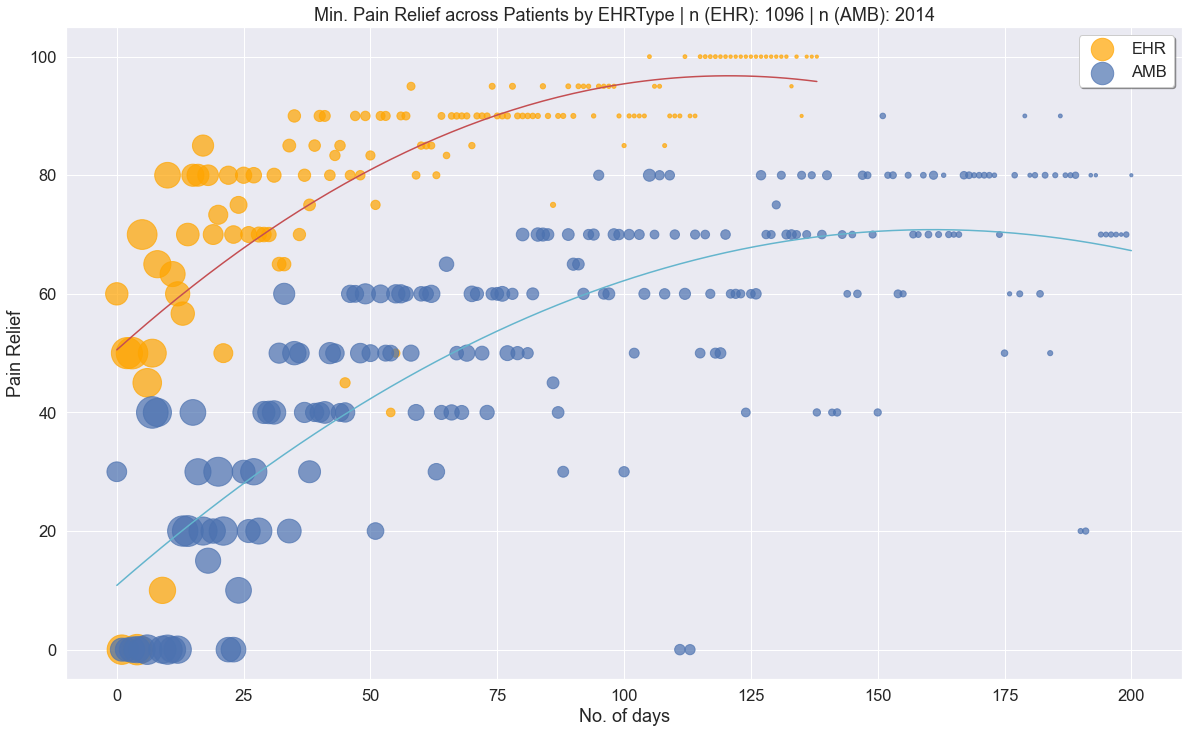

In [66]:
fig, ax = plt.subplots()
x_ehr = df_p3[df_p3['EHRType'] == 'EHR']['hos_days']
y_ehr = df_p3[df_p3['EHRType'] == 'EHR']['pain_relief']['min']
coeffs = np.polyfit(x_ehr,y_ehr,deg=2)
l1 = ax.scatter(x_ehr, y_ehr, color='orange', s=get_scatter_marker_size(df_p3[df_p3['EHRType']=='EHR']['IDEHR']['count']), alpha=0.7)
ax.plot(x_ehr, coeffs[0]*x_ehr**2 + coeffs[1]*x_ehr + coeffs[2], color='r')
x_amb = df_p3[df_p3['EHRType'] == 'AMB']['hos_days']
y_amb = df_p3[df_p3['EHRType'] == 'AMB']['pain_relief']['min']
coeffs = np.polyfit(x_amb,y_amb,deg=2)
l2 = ax.scatter(x_amb, y_amb, color='b', s=get_scatter_marker_size(df_p3[df_p3['EHRType']=='AMB']['IDEHR']['count']), alpha=0.7)
ax.plot(x_amb, coeffs[0]*x_amb**2 + coeffs[1]*x_amb + coeffs[2], color='c')
ax.legend((l1, l2), ('EHR', 'AMB'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Min. Pain Relief across Patients by EHRType | n (EHR): ' + str(e_num) + ' | n (AMB): ' + str(a_num))
plt.savefig('./graphs/pain control/pain_min_ehr_2.png', bbox_inches='tight')
plt.show()

In [67]:
# min. pain relief by setting
df_p5 = df_st[['IDEHR', 'Setting', 'hos_days', 'pain_relief']].groupby(by=['Setting', 'hos_days']).agg(['min', 'count']).reset_index()
df_p5

Setting hos_days IDEHR       pain_relief      
                                    min count         min count
0              Domicilio        0  1760   244   30.000000   244
1              Domicilio        1  3453   331    0.000000   331
2              Domicilio        2  3417   339    0.000000   339
3              Domicilio        3  1760   402    0.000000   402
4              Domicilio        4  3453   428    0.000000   428
...                  ...      ...   ...   ...         ...   ...
1036  Hospice Pediatrico       18  3610     1   86.666667     1
1037  Hospice Pediatrico       19  3610     1   90.000000     1
1038  Hospice Pediatrico       20  3610     1   90.000000     1
1039  Hospice Pediatrico       21  3610     1   90.000000     1
1040  Hospice Pediatrico       22  3610     1   95.000000     1

[1041 rows x 6 columns]

In [68]:
d_num = len(df_st[df_st['Setting'] == 'Domicilio'].IDEHR.unique())
h_num = len(df_st[df_st['Setting'] == 'Hospice'].IDEHR.unique())
df_p6 = df_p5[df_p5['hos_days'] <= 200]

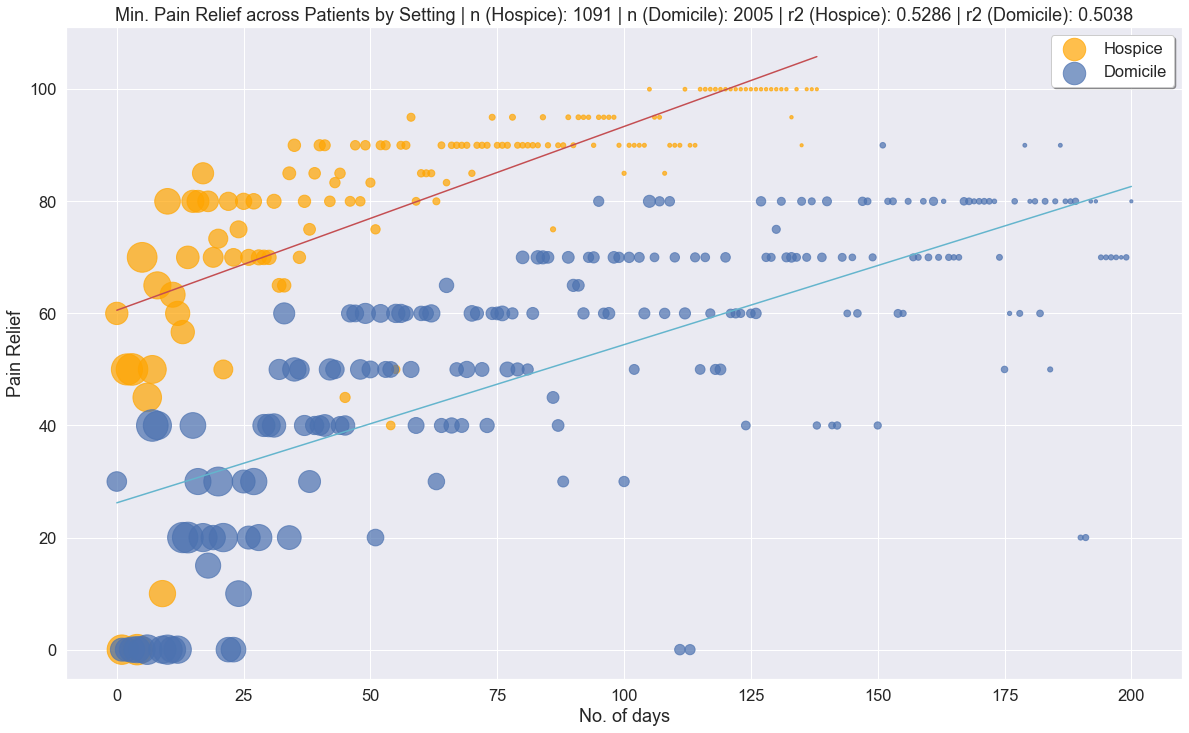

In [69]:
fig, ax = plt.subplots()
x_hos = df_p6[df_p6['Setting'] == 'Hospice']['hos_days']
y_hos = df_p6[df_p6['Setting'] == 'Hospice']['pain_relief']['min']
slope, intercept, r_value_hos, p_value, std_err = stats.linregress(x_hos,y_hos)
l1 = ax.scatter(x_hos, y_hos, color='orange', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Hospice']['IDEHR']['count']), alpha=0.7)
ax.plot(x_hos, slope*x_hos + intercept, color='r')
x_dom = df_p6[df_p6['Setting'] == 'Domicilio']['hos_days']
y_dom = df_p6[df_p6['Setting'] == 'Domicilio']['pain_relief']['min']
slope, intercept, r_value_dom, p_value, std_err = stats.linregress(x_dom,y_dom)
l2 = ax.scatter(x_dom, y_dom, color='b', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Domicilio']['IDEHR']['count']), alpha=0.7)
ax.plot(x_dom, slope*x_dom + intercept, color='c')
ax.legend((l1, l2), ('Hospice', 'Domicile'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Min. Pain Relief across Patients by Setting | n (Hospice): ' + str(h_num) + ' | n (Domicile): ' + str(d_num) + ' | r2 (Hospice): ' + "{:.4f}".format(r_value_hos ** 2) + " | r2 (Domicile): " + "{:.4f}".format(r_value_dom ** 2))
plt.savefig('./graphs/pain control/pain_min_set.png', bbox_inches='tight')
plt.show()

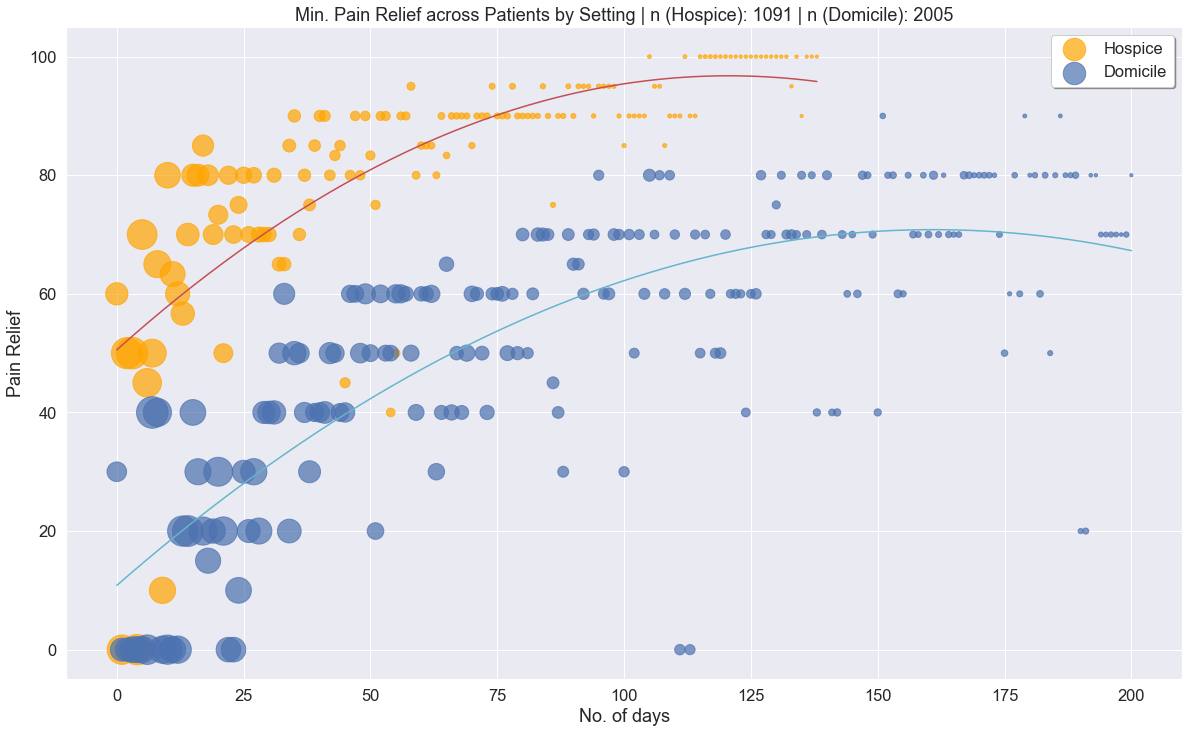

In [70]:
fig, ax = plt.subplots()
x_hos = df_p6[df_p6['Setting'] == 'Hospice']['hos_days']
y_hos = df_p6[df_p6['Setting'] == 'Hospice']['pain_relief']['min']
coeffs = np.polyfit(x_hos,y_hos,deg=2)
l1 = ax.scatter(x_hos, y_hos, color='orange', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Hospice']['IDEHR']['count']), alpha=0.7)
ax.plot(x_hos, coeffs[0]*x_hos**2 + coeffs[1]*x_hos + coeffs[2], color='r')
x_dom = df_p6[df_p6['Setting'] == 'Domicilio']['hos_days']
y_dom = df_p6[df_p6['Setting'] == 'Domicilio']['pain_relief']['min']
coeffs = np.polyfit(x_dom,y_dom,deg=2)
l2 = ax.scatter(x_dom, y_dom, color='b', s=get_scatter_marker_size(df_p6[df_p6['Setting']=='Domicilio']['IDEHR']['count']), alpha=0.7)
ax.plot(x_dom, coeffs[0]*x_dom**2 + coeffs[1]*x_dom + coeffs[2], color='c')
ax.legend((l1, l2), ('Hospice', 'Domicile'), loc='best', shadow=True, facecolor='w')
ax.set_xlabel('No. of days')
ax.set_ylabel('Pain Relief')
ax.set_title('Min. Pain Relief across Patients by Setting | n (Hospice): ' + str(h_num) + ' | n (Domicile): ' + str(d_num))
plt.savefig('./graphs/pain control/pain_min_set_2.png', bbox_inches='tight')
plt.show()

In [71]:
# heatmaps of min pain relief across diagnosis
d_label = df_pa[df_pa['hos_days'] <= 90][['IDEHR', 'Diagnosis']].groupby(by=['Diagnosis']).nunique().stack()
df_p4 = df_pa[['Diagnosis', 'hos_days', 'pain_relief']].groupby(by=['Diagnosis', 'hos_days']).min().reset_index()
df_p4 = df_p4[df_p4['hos_days'] <= 90]
df_p4['Diagnosis'] = df_p4['Diagnosis'].apply(lambda x: np.nan if isinstance(x, float) else x + ' (n: ' + str(d_label[x][0]) + ')')
p_num = d_label.sum()
df_p4 = df_p4.pivot(index='Diagnosis', columns='hos_days', values='pain_relief')
df_p4

hos_days,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 86),80.0,85.000000,90.0,60.0,80.0,80.0,60.0,70.0,85.0,60.0,...,100.0,90.0,90.0,90.0,90.0,70.0,90.0,100.0,90.0,90.0
Breast (n: 230),60.0,40.000000,50.0,40.0,70.0,70.0,40.0,70.0,40.0,50.0,...,90.0,80.0,70.0,90.0,80.0,65.0,70.0,65.0,80.0,65.0
Cervical-Ovarian (n: 157),50.0,70.000000,80.0,70.0,70.0,65.0,80.0,70.0,70.0,50.0,...,80.0,80.0,80.0,80.0,80.0,70.0,70.0,80.0,90.0,80.0
GI Tract (n: 509),60.0,60.000000,50.0,50.0,50.0,0.0,50.0,60.0,60.0,50.0,...,80.0,80.0,70.0,80.0,90.0,45.0,80.0,80.0,80.0,80.0
Genitourinary (n: 172),50.0,80.000000,50.0,70.0,60.0,70.0,50.0,40.0,65.0,30.0,...,80.0,95.0,80.0,90.0,80.0,75.0,80.0,80.0,80.0,80.0
Head-Neck (n: 67),70.0,70.000000,70.0,60.0,0.0,90.0,70.0,70.0,70.0,70.0,...,90.0,90.0,100.0,100.0,90.0,NaN,90.0,90.0,90.0,NaN
Liver-Biliary (n: 217),70.0,30.000000,80.0,60.0,60.0,60.0,60.0,70.0,70.0,80.0,...,90.0,80.0,80.0,90.0,80.0,80.0,90.0,100.0,80.0,80.0
Lung (n: 636),30.0,0.000000,50.0,40.0,50.0,50.0,50.0,50.0,40.0,10.0,...,80.0,70.0,80.0,80.0,70.0,70.0,70.0,70.0,70.0,80.0
Lymphoid_Leukemia (n: 10),100.0,100.000000,100.0,100.0,90.0,90.0,90.0,90.0,95.0,90.0,...,NaN,85.0,NaN,90.0,90.0,NaN,NaN,90.0,90.0,NaN


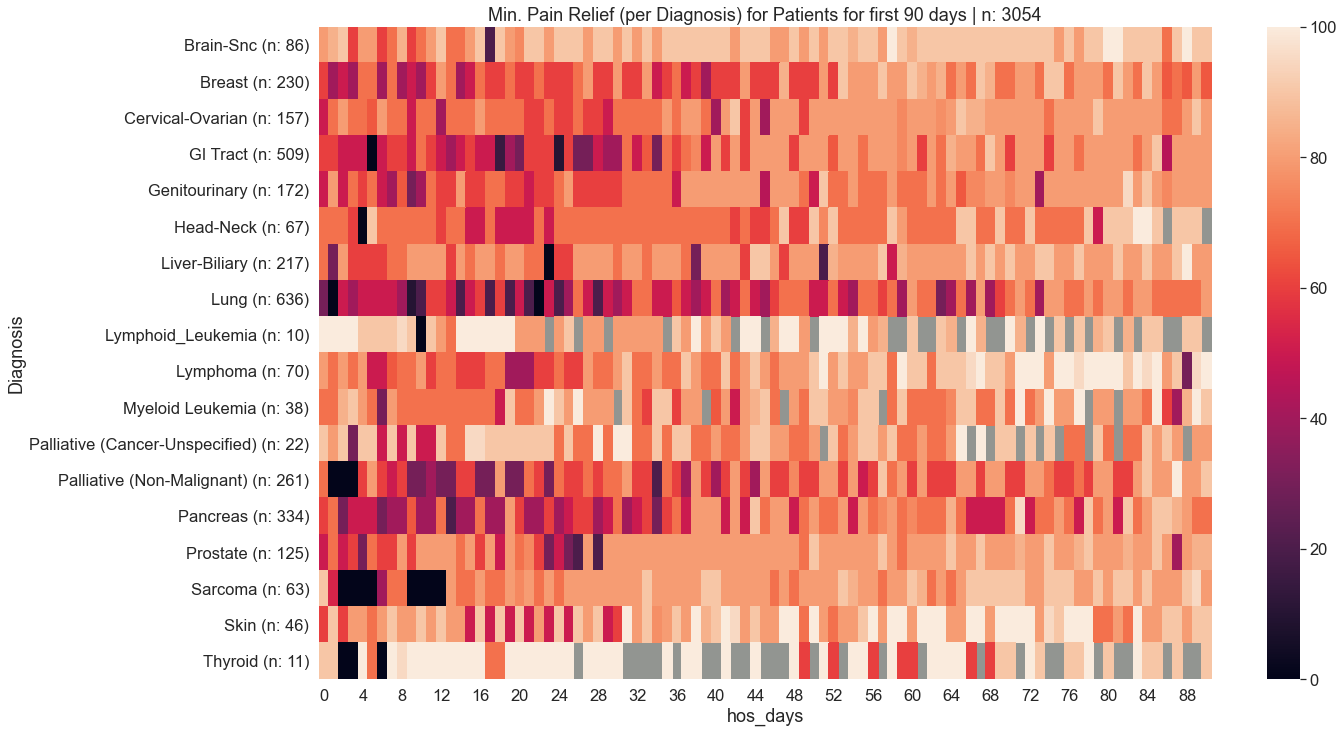

In [72]:
ax = plt.axes()
sns.heatmap(df_p4, annot=False, fmt='g', ax=ax, xticklabels=4)
ax.set_facecolor('xkcd:gray')
ax.set_title('Min. Pain Relief (per Diagnosis) for Patients for first 90 days | n: ' + str(p_num))
plt.savefig('./graphs/pain control/pain_min_f90.png', bbox_inches='tight')
plt.show()

In [73]:
get_coeffs(df_p4, 90)

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,deg1 (m),deg2 (x2),deg2 (x1)
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 86),80.0,85.000000,90.0,60.0,80.0,80.0,60.0,70.0,85.0,60.0,...,90.0,90.0,70.0,90.0,100.0,90.0,90.0,0.18,-0,0.46
Breast (n: 230),60.0,40.000000,50.0,40.0,70.0,70.0,40.0,70.0,40.0,50.0,...,90.0,80.0,65.0,70.0,65.0,80.0,65.0,0.31,-0,0.59
Cervical-Ovarian (n: 157),50.0,70.000000,80.0,70.0,70.0,65.0,80.0,70.0,70.0,50.0,...,80.0,80.0,70.0,70.0,80.0,90.0,80.0,0.21,0,0.2
GI Tract (n: 509),60.0,60.000000,50.0,50.0,50.0,0.0,50.0,60.0,60.0,50.0,...,80.0,90.0,45.0,80.0,80.0,80.0,80.0,0.45,-0,0.71
Genitourinary (n: 172),50.0,80.000000,50.0,70.0,60.0,70.0,50.0,40.0,65.0,30.0,...,90.0,80.0,75.0,80.0,80.0,80.0,80.0,0.27,-0,0.41
Head-Neck (n: 67),70.0,70.000000,70.0,60.0,0.0,90.0,70.0,70.0,70.0,70.0,...,100.0,90.0,NaN,90.0,90.0,90.0,NaN,undef,undef,undef
Liver-Biliary (n: 217),70.0,30.000000,80.0,60.0,60.0,60.0,60.0,70.0,70.0,80.0,...,90.0,80.0,80.0,90.0,100.0,80.0,80.0,0.23,0,0.21
Lung (n: 636),30.0,0.000000,50.0,40.0,50.0,50.0,50.0,50.0,40.0,10.0,...,80.0,70.0,70.0,70.0,70.0,70.0,80.0,0.47,0,0.43
Lymphoid_Leukemia (n: 10),100.0,100.000000,100.0,100.0,90.0,90.0,90.0,90.0,95.0,90.0,...,90.0,90.0,NaN,NaN,90.0,90.0,NaN,undef,undef,undef


In [74]:
s_time = 30
df_p6 = df_pa[df_pa['survival_time_days'] >= s_time]
df_p6 = df_p6[df_p6['hos_days'] <= s_time]
d_label = df_p6[df_p6['hos_days'] <= s_time][['IDEHR', 'Diagnosis']].groupby(by=['Diagnosis']).nunique().stack()
p_num = d_label.sum()
df_p6 = df_p6[['Diagnosis', 'hos_days', 'pain_relief']].groupby(by=['Diagnosis', 'hos_days']).min().reset_index()
df_p6 = df_p6[df_p6['hos_days'] <= s_time]
df_p6['Diagnosis'] = df_p6['Diagnosis'].apply(lambda x: np.nan if isinstance(x, float) else x + ' (n: ' + str(d_label[x][0]) + ')')
df_p6 = df_p6.pivot(index='Diagnosis', columns='hos_days', values='pain_relief')
df_p6

hos_days,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 35),80.0,90.0,90.0,80.0,80.0,90.0,80.0,80.0,90.0,90.0,...,90.0,90.0,80.0,90.0,90.0,90.0,80.0,90.0,90.0,80.0
Breast (n: 78),60.0,40.0,70.0,40.0,90.0,70.0,40.0,70.0,40.0,50.0,...,60.0,70.0,60.0,60.0,60.0,70.0,80.0,60.0,60.0,80.0
Cervical-Ovarian (n: 57),80.0,80.0,90.0,80.0,70.0,75.0,80.0,70.0,90.0,80.0,...,70.0,60.0,70.0,60.0,60.0,70.0,60.0,60.0,50.0,70.0
GI Tract (n: 192),60.0,60.0,50.0,60.0,50.0,80.0,50.0,60.0,60.0,50.0,...,60.0,60.0,60.0,10.0,60.0,30.0,60.0,50.0,40.0,40.0
Genitourinary (n: 62),50.0,80.0,50.0,70.0,60.0,70.0,50.0,40.0,65.0,30.0,...,50.0,60.0,60.0,70.0,85.0,60.0,60.0,60.0,60.0,60.0
Head-Neck (n: 24),70.0,70.0,70.0,60.0,70.0,100.0,70.0,70.0,70.0,70.0,...,50.0,70.0,50.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
Liver-Biliary (n: 71),80.0,30.0,80.0,60.0,60.0,80.0,60.0,80.0,80.0,80.0,...,80.0,80.0,80.0,90.0,80.0,80.0,80.0,80.0,80.0,70.0
Lung (n: 222),70.0,80.0,50.0,40.0,60.0,70.0,70.0,60.0,50.0,60.0,...,20.0,0.0,50.0,20.0,40.0,70.0,50.0,20.0,50.0,40.0
Lymphoid_Leukemia (n: 4),100.0,100.0,NaN,100.0,90.0,90.0,90.0,NaN,100.0,90.0,...,80.0,80.0,NaN,80.0,90.0,NaN,80.0,80.0,NaN,80.0


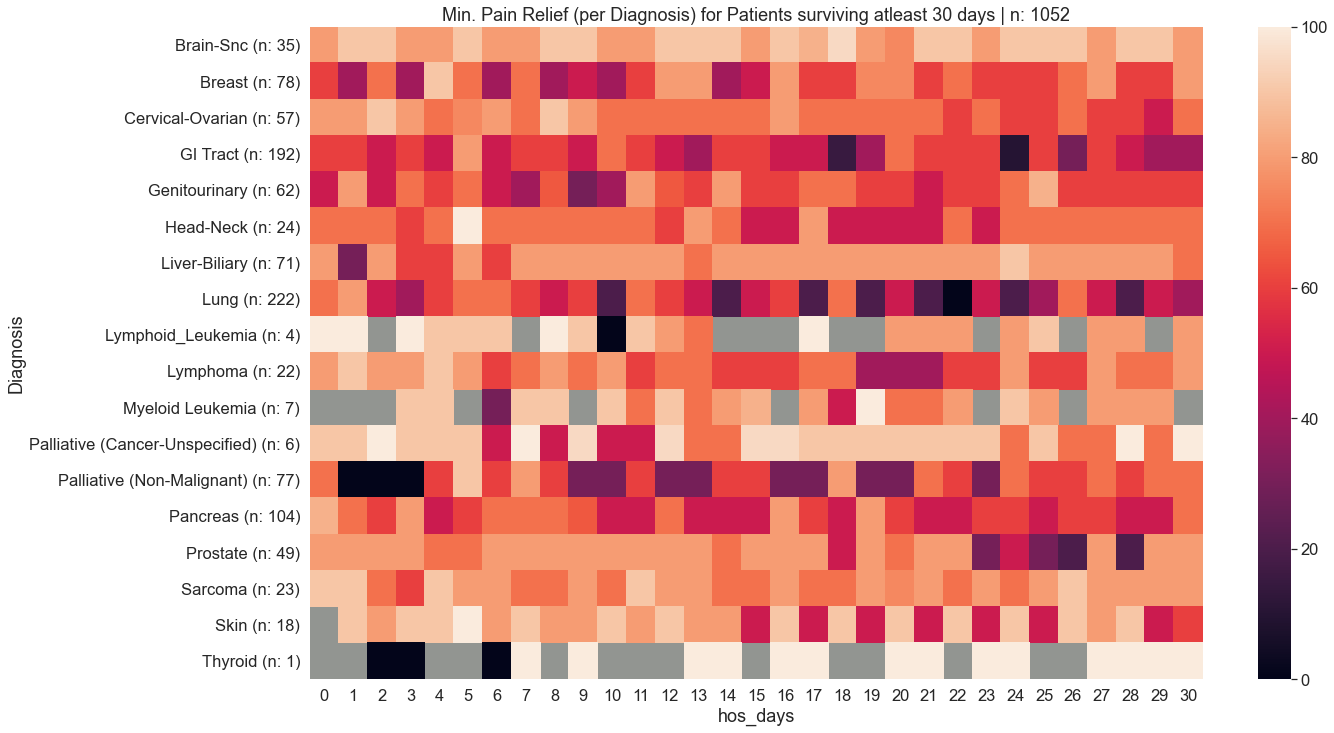

In [75]:
ax = plt.axes()
sns.heatmap(df_p6, annot=False, fmt='.2g', ax=ax)
ax.set_facecolor('xkcd:gray')
ax.set_title('Min. Pain Relief (per Diagnosis) for Patients surviving atleast ' + str(s_time) + ' days | n: ' + str(p_num))
plt.savefig('./graphs/pain control/pain_min_a30.png', bbox_inches='tight')
plt.show()

In [76]:
get_coeffs(df_p6, 30)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,deg1 (m),deg2 (x2),deg2 (x1)
Diagnosis,,,,,,,,,,,,,,,,,,,,,
Brain-Snc (n: 35),80.0,90.0,90.0,80.0,80.0,90.0,80.0,80.0,90.0,90.0,...,90.0,90.0,90.0,80.0,90.0,90.0,80.0,0.07,-0.01,0.22
Breast (n: 78),60.0,40.0,70.0,40.0,90.0,70.0,40.0,70.0,40.0,50.0,...,60.0,60.0,70.0,80.0,60.0,60.0,80.0,0.47,0.01,0.27
Cervical-Ovarian (n: 57),80.0,80.0,90.0,80.0,70.0,75.0,80.0,70.0,90.0,80.0,...,60.0,60.0,70.0,60.0,60.0,50.0,70.0,-0.72,-0,-0.63
GI Tract (n: 192),60.0,60.0,50.0,60.0,50.0,80.0,50.0,60.0,60.0,50.0,...,10.0,60.0,30.0,60.0,50.0,40.0,40.0,-0.59,-0,-0.46
Genitourinary (n: 62),50.0,80.0,50.0,70.0,60.0,70.0,50.0,40.0,65.0,30.0,...,70.0,85.0,60.0,60.0,60.0,60.0,60.0,0.2,-0,0.26
Head-Neck (n: 24),70.0,70.0,70.0,60.0,70.0,100.0,70.0,70.0,70.0,70.0,...,70.0,70.0,70.0,70.0,70.0,70.0,70.0,-0.28,0.05,-1.67
Liver-Biliary (n: 71),80.0,30.0,80.0,60.0,60.0,80.0,60.0,80.0,80.0,80.0,...,90.0,80.0,80.0,80.0,80.0,80.0,70.0,0.52,-0.05,2.15
Lung (n: 222),70.0,80.0,50.0,40.0,60.0,70.0,70.0,60.0,50.0,60.0,...,20.0,40.0,70.0,50.0,20.0,50.0,40.0,-1,0.06,-2.77
Lymphoid_Leukemia (n: 4),100.0,100.0,NaN,100.0,90.0,90.0,90.0,NaN,100.0,90.0,...,80.0,90.0,NaN,80.0,80.0,NaN,80.0,undef,undef,undef
